# Parser

In [ ]:
pip install antlr4-python3-runtime


     |████████████████████████████████| 116 kB 4.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.10-py3-none-any.whl size=144171 sha256=8dc794825cb5984544c9bc25a9855d6080ee82c102bcc15b22465ea901d3d6c1
  Stored in directory: /root/.cache/pip/wheels/f0/3d/4d/b5f9dab12f8e1e752959553da73f44289afa5c2dd47fa377d7
Successfully built antlr4-python3-runtime


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/MyDrive/ArshadPeoject')

Mounted at /content/gdrive


In [ ]:
from antlr4 import *
from antlr4.tree.Tree import TerminalNodeImpl
from my_parser.antlr.query.QueryLexer import QueryLexer
from my_parser.antlr.query.QueryParser import QueryParser
from my_parser.antlr.query.QueryVisitor import QueryVisitor

from my_parser.antlr.path.PathLexer import PathLexer
from my_parser.antlr.path.PathParser import PathParser
from my_parser.antlr.path.PathVisitor import PathVisitor

import re

import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# class MyParser(HttpGrammarParser):
#   def accept(self, visitor:ParseTreeVisitor):
#     print("a - " , visitor.getRuleIndex())
#     return super().accept(visitor)

# class MyVisitor(HttpGrammarVisitor):
#   def decompose(self, root):
#     pass

#   def visit(self, tree):
#     print("v -" , tree.getRuleIndex())
#     return super().visit(tree)

 
          
#   def visitChildren(self, ctx):
#     # print("ss")
#     # ctx.getLeaf()
#     print("child -" , ctx.getRuleIndex())
#     print("c -" ,type(ctx))

#     ss = super().visitChildren(ctx)
#     # print(ss)
#     return ss
  
#     # def cus_visit(node,  root , S):


    

In [ ]:
class Node:
    def __init__(self, name, parent=None):
        self.name = name
        self.parent = parent
        self.children = []
        # ...

        if parent:
            self.parent.children.append(self)

def nodize(tree, p=None):
  
  if not isinstance(tree, TerminalNodeImpl):
    root = Node("<" + str(tree).split(' ')[0].replace("[","").replace("]","") + ">", p)
    for i in tree.getChildren():
      nodize(i,root)
  else:
    root = Node("'" +str(tree)+ "'", p)
  return root


def print_tree(current_node, indent="", last='updown'):

    nb_children = lambda node: sum(nb_children(child) for child in node.children) + 1
    size_branch = {child: nb_children(child) for child in current_node.children}

    """ Creation of balanced lists for "up" branch and "down" branch. """
    up = current_node.children
    down = []
    while up and sum(size_branch[node] for node in down) < sum(size_branch[node] for node in up):
        down.append(up.pop())

    """ Printing of "up" branch. """
    for child in up:     
        next_last = 'up' if up.index(child) is 0 else ''
        next_indent = '{0}{1}{2}'.format(indent, ' ' if 'up' in last else '│', " " * len(current_node.name))
        print_tree(child, indent=next_indent, last=next_last)

    """ Printing of current node. """
    if last == 'up': start_shape = '┌'
    elif last == 'down': start_shape = '└'
    elif last == 'updown': start_shape = ' '
    else: start_shape = '├'

    if up: end_shape = '┤'
    elif down: end_shape = '┐'
    else: end_shape = ''

    print ('{0}{1}{2}{3}'.format(indent, start_shape, current_node.name, end_shape))

    """ Printing of "down" branch. """
    for child in down:
        next_last = 'down' if down.index(child) is len(down) - 1 else ''
        next_indent = '{0}{1}{2}'.format(indent, ' ' if 'down' in last else '│', " " * len(current_node.name))
        print_tree(child, indent=next_indent, last=next_last)

In [ ]:
def getLeaf(root,prev):
  leaf=set()
  if not isinstance(root, TerminalNodeImpl):
    for i in root.getChildren():
      leaf.update(getLeaf(i,root))
  else:
    leaf.add(str(prev).split(' ')[0].replace("[","").replace("]",""))
  return leaf
  

vector is : [path_vector].concat([query_Vector])

In [ ]:
def decomposeTree(root):
  S=set()
  children=root.getChildren()
  for child in children:
    visit(child,root,S)
  return S

def visit(node,root,S):
  rootLeafs= getLeaf(root)
  childLeafs = getLeaf(node)
  diff=rootLeafs.difference(childLeafs)
  extr=False
  if not isinstance(node, TerminalNodeImpl):
    children=node.getChildren()
    for child in children:
      extr=visit(child,node,S)
  if len(diff)>0 and not extr:
    S.add("<" + str(node).split(' ')[0].replace("[","").replace("]","") + ">")
    extr=True
  return extr
  

In [ ]:
def getStates0(tree, root, S):
   rootLeafs= getLeaf(root,None)
  #  print(rootLeafs)
   childLeafs = getLeaf(tree,None)
  #  print(childLeafs)
   diff=rootLeafs.difference(childLeafs)
  #  print(diff)
  #  print(len(diff))
   extr=False
   if not isinstance(tree, TerminalNodeImpl): 
     state = str(tree).split(' ')[0].replace("[","").replace("]","")      #  print(state)
     if len(diff)>0 and not extr:
      # print(state , " | ", tree.getText())
      txt =tree.getText();
      nsc=len(re.sub('[\w]+' ,'', txt))
      lav=len(txt)
      rml=4096
      t=S[1][int(state)]*S[0][int(state)]
      S[0][int(state)]+=1
      S[1][int(state)]=( t + int((1+(nsc/lav))*rml) + lav)/S[0][int(state)]
      
      extr=True
     ch=tree.getChildren()
     prev=tree
     for c in ch:
       getStates0(c,prev, S)
       prev=c  

# def getStates(dfa_states, s):
#   for k in dfa_states:
#     if k!=None and not k.stateNumber in s:
#       s.add(k.stateNumber)
#       if k.edges!=None:
#           getStates(k.edges,s)
  
def getStates(tree, S):
  #  S.add("<" + str(tree).split(' ')[0].replace("[","").replace("]","") + ">")
   if not isinstance(tree, TerminalNodeImpl): 
     state = str(tree).split(' ')[0].replace("[","").replace("]","")
    #  if state!='':
    #   #  print(state)
    #    S[int(state)]+=1
     ch=tree.getChildren()
     prev=tree
     for c in ch:
       getStates0(c,prev, S)
       prev=c


In [ ]:
import re
x = "asdfkls2df#$&rwefe^ef#wef@!"
new = len(re.sub('[\w]+' ,'', x))
print(new)

7


In [ ]:
# def getStates0(tree, root, S):
#   #  rootLeafs= getLeaf(root)
#   #  childLeafs = getLeaf(tree)
#   #  diff=rootLeafs.difference(childLeafs)
#    extr=False
#    if not isinstance(tree, TerminalNodeImpl): 
#      state = str(tree).split(' ')[0].replace("[","").replace("]","")
#       #  print(state)
#      ch=tree.getChildren()
#      prev=tree
#      for c in ch:
#        extr=getStates0(c,prev, S)
#        prev=c  
#     #  if len(diff)>0 and not extr:
#     #  print(state)
#      print(state , " | ", tree.getText())
#      S[int(state)]+=1
#       #  extr=True
#    return extr


# # def getStates(dfa_states, s):
# #   for k in dfa_states:
# #     if k!=None and not k.stateNumber in s:
# #       s.add(k.stateNumber)
# #       if k.edges!=None:
# #           getStates(k.edges,s)
  
# def getStates(tree, S):
#   #  S.add("<" + str(tree).split(' ')[0].replace("[","").replace("]","") + ">")
#    if not isinstance(tree, TerminalNodeImpl): 

#      state = str(tree).split(' ')[0].replace("[","").replace("]","")
#      print(tree.getText())
#      if state!='':
#       #  print(state)
#        print(state , " | ", tree.getText())
#        S[int(state)]+=1
#      ch=tree.getChildren()
#      for c in ch:
#        getStates0(c,tree, S)


In [ ]:
# 
url = "http://localhost:8080/tienda1/imagenes/1.gif".lower()

path_start=url.index("/", url.index("/")+2)
try:
  path_end=url.index("?")
except:
  path_end=len(url)

basic = url[:path_start]
path = url[path_start+1:path_end]
query = url[path_end+1:]
print(path)
q_data = InputStream(query)
p_data = InputStream(path)

q_lexer = QueryLexer(q_data)
q_stream = CommonTokenStream(q_lexer)
q_parser =QueryParser(q_stream)
q_tree = q_parser.query()
print_tree(nodize(q_tree))
p_lexer = PathLexer(p_data)
p_stream = CommonTokenStream(p_lexer)
p_parser =PathParser(p_stream)
p_tree = p_parser.path()
print_tree(nodize(p_tree))


query_vector =[0]*65
print(query_vector)


tienda1/imagenes/1.gif


NameError: ignored

In [ ]:
def parse(url):
  
  url=url.lower()
  path_start=url.index("/", url.index("//")+1)
  try:
    path_end=url.index("?")
  except:
    path_end=len(url)

  basic = url[:path_start]
  path = url[path_start+1:path_end]
  query = url[path_end+1:]

  q_vec=np.zeros((2,285))
  p_vec=np.zeros((2,235))
  if query == '': 
    query=None
  if path=='':
    path=None
  if query!=None:
    q_data = InputStream(query)
    q_lexer = QueryLexer(q_data)
    q_stream = CommonTokenStream(q_lexer)
    q_parser =QueryParser(q_stream)
    q_tree = q_parser.query()
    getStates(q_tree, q_vec)
    visitor = QueryVisitor()
    output =visitor.visit(q_tree)
  # print("===========================================")
  if path!=None:
    p_data = InputStream(path)
    p_lexer = PathLexer(p_data)
    p_stream = CommonTokenStream(p_lexer)
    p_parser =PathParser(p_stream)
    p_tree = p_parser.path()
    getStates(p_tree, p_vec)
    visitor = PathVisitor()
    output =visitor.visit(p_tree)
  # print(len(p_vec[1]))
  # print("==================")
  # print(p_vec[0])
  # print("  --  ")
  # print(p_vec[1])
  # print("==================")
  # print(q_vec[1])
  # return np.concatenate((p_vec[1], q_vec[1]))
  return q_vec,q_tree, p_vec,p_tree


In [ ]:

url= "http://localhost:8080/tienda1/miembros/editar.jsp?te=select+*+from+tb_ss+where+1=1&modo=registro&login=olson&password=conFesuR%CDA&nombre=Aberardo&apellidos=Segovia&email=raya%40acumulador.com.iq&dni=06076324T&direccion=Calle+Atarfe%F1o%2C+1%2B15%2C+&ciudad=Marug%E1n&cp=15589&provincia=Lleida&ntc=0903154438828489&B1=Registrar".lower()
# path_start=url.index("/", url.index("/")+2)
# try:
#   path_end=url.index("?")
# except:
#   path_end=len(url)

# basic = url[:path_start]
# path = url[path_start+1:path_end]
# query = url[path_end+1:]
# print(path)
# q_data = InputStream(query)
# p_data = InputStream(path)

# q_lexer = QueryLexer(q_data)
# q_stream = CommonTokenStream(q_lexer)
# q_parser =QueryParser(q_stream)
# q_tree = q_parser.query()
# print_tree(nodize(q_tree))
# p_lexer = PathLexer(p_data)
# p_stream = CommonTokenStream(p_lexer)
# p_parser =PathParser(p_stream)
# p_tree = p_parser.path()
# print_tree(nodize(p_tree))


# query_vector =[0]*65
# print(query_vector)
q, q_t, p, p_t = parse(url)
print(q[0])
# print(q[1])

print("=====")
print_tree(nodize(q_t))
# print(p[0])
# print(p[1])



# # print(url[406:])
# # url= "get http:/dpxd.er.ui:8080/p2/ppath2/path_47-8rt?q=w&q=re&e=sd-4de-6"
# # url = "get https:/colab.research.google.com/drive/sel/se-d_m/sed34-ws/sdw_er4-w/a33sdr-t15iiki-_v/ty5-der_sdw?p=qwe&qw23w=25,w=sdw-s dd96,r=ade,edef4,rfrf4_de-&buery=select * from tb_test where 1=1".lower()
# v =parse("https://stackoverflow.com/questions/42905267/antlr-error-no-viable-alternative-at-input-eof")

# print(v)
# query_vector =[0]*65
# path_vector= [0]*65

In [ ]:
# for i in range(0,len(v)):
#   if v[i] >0:
#     print(i,"=",v[i])

In [ ]:
# for i in range(0,len(v)):
#   if v[i] >0:
#     print(i,"=",v[i])

In [ ]:
# for i in range(0,len(v)):
#   if v[i] >0:
#     print(i,"=",v[i])

In [ ]:
import csv

def analyse(p):
  
  tmp= p.split('\n')
  if(p.startswith("GET")):
    tm = tmp[0].split(' ')
    return tm[0]+' '+tm[1]
  tm = tmp[0].split(' ')
  # print(tmp)
  return tm[0]+' '+tm[1]+ '?' +tmp[len(tmp)-3]
  
def readLangs(lang1, lang2, path, reverse=False):
    c=["col"]*520
    print(c)
    for i in range(0,520):
      c[i]="col-"+str(i)
    f = open('/content/gdrive/MyDrive/ArshadPeoject/data/anomalousTrafficTest.csv', "w")
    cw = csv.writer(f)
    cw.writerow(c)
    print("Reading lines...")

    # Read the file and split into lines
    filedata = open(path, encoding='utf-8').\
        read().strip()
    filedata = re.sub(r"GET", r"@GET", filedata)
    filedata = re.sub(r"POST", r"@POST", filedata)
    lines= filedata.split("@")
    lines= lines[1:]
    # print(lines[20982])
    # Split every line into pairs and normalize
    # pairs = [[normalizeString(s) for s in [l,l]] for l in lines]
    for l in lines:
      cw.writerow(parse(analyse(l)))
    f.close()

In [ ]:
import random
def init_test_validation_data():
  anomal_file = open('/content/gdrive/MyDrive/ArshadPeoject/data/anomalousTrafficTest.csv', "r")
  normal_file = open('/content/gdrive/MyDrive/ArshadPeoject/data/normalTrafficTest.csv', "r")

  normal_valid = open('/content/gdrive/MyDrive/ArshadPeoject/data/normal_valid.csv', "w")
  normall_test = open('/content/gdrive/MyDrive/ArshadPeoject/data/normal_test.csv', "w")

  valid_write =csv.writer(normal_valid)
  test_write  =csv.writer(normall_test)
  c=["col"]*520
  for i in range(0,520):
    c[i]="col-"+str(i)


  reader = csv.reader(normal_file)
  a=list()
  isFirst=False
  valid_write.writerow(c)
  test_write.writerow(c)
  for row in reader:
    if not isFirst:
      isFirst=True
    else:
      a.append(row)
  random.shuffle(a)
  count =int(0.2*len(a))
  for i in range(0,len(a)):
    if i <count:
      valid_write.writerow(a[i])
    else:
      test_write.writerow(a[i])

  normal_valid.close()
  normall_test.close()
  #===============================================
  anomal_valid = open('/content/gdrive/MyDrive/ArshadPeoject/data/anomalous_valid.csv', "w")
  anomal_test = open('/content/gdrive/MyDrive/ArshadPeoject/data/anomalous_test.csv', "w")
  valid_write =csv.writer(anomal_valid)
  test_write  =csv.writer(anomal_test)

  reader = csv.reader(anomal_file)
  a=list()
  isFirst=False
  valid_write.writerow(c)
  test_write.writerow(c)
  for row in reader:
    if not isFirst:
      isFirst=True
    else:
      a.append(row)
  random.shuffle(a)
  count =int(0.2*len(a))
  for i in range(0,len(a)):
    if i <count:
      valid_write.writerow(a[i])
    else:
      test_write.writerow(a[i])

  anomal_valid.close()
  anomal_test.close()

In [ ]:
# anomal_file = open('/content/gdrive/MyDrive/ArshadPeoject/data/normalTrafficTest.csv', "r")
# rrr = csv.reader(anomal_file)
# r=0
# for row in rrr:
#   print(row)
#   print(len(row))
#   r+=1
#   if r==5: 
#     pass


In [ ]:
# anorm_train.close()
# anorm_test.close()

# readLangs('eng', 'fra', '/content/gdrive/MyDrive/ArshadPeoject/data/raw_data/anomalousTrafficTest.txt', False)
# print("done")

In [ ]:
# init_test_validation_data()

In [ ]:
import time
import click
import torch
import logging
import random
import numpy as np
import torch.nn as nn
from abc import ABC, abstractmethod
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Base

In [ ]:
class BaseADDataset(ABC):
    """Anomaly detection dataset base class."""

    def __init__(self, root: str):
        super().__init__()
        self.root = root  # root path to data

        self.n_classes = 2  # 0: normal, 1: outlier
        self.normal_classes = None  # tuple with original class labels that define the normal class
        self.outlier_classes = None  # tuple with original class labels that define the outlier class

        self.train_set = None  # must be of type torch.utils.data.Dataset
        self.test_set = None  # must be of type torch.utils.data.Dataset
        self.validation_set = None

    @abstractmethod
    def loaders(self, batch_size: int, shuffle_train=True, shuffle_test=False, num_workers: int = 0) -> (
            DataLoader, DataLoader):
        """Implement data loaders of type torch.utils.data.DataLoader for train_set and test_set."""
        pass

    def __repr__(self):
        return self.__class__.__name__

In [ ]:
class BaseNet(nn.Module):
    """Base class for all neural networks."""

    def __init__(self):
        super().__init__()
        self.logger = logging.getLogger(self.__class__.__name__)
        self.rep_dim = None  # representation dimensionality, i.e. dim of the last layer

    def forward(self, *input):
        """
        Forward pass logic
        :return: Network output
        """
        raise NotImplementedError

    def summary(self):
        """Network summary."""
        net_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in net_parameters])
        print('Trainable parameters: {}'.format(params))
        print(self)

In [ ]:
class BaseTrainer(ABC):
    """Trainer base class."""

    def __init__(self, optimizer_name: str, lr: float, n_epochs: int, lr_milestones: tuple, batch_size: int,
                 weight_decay: float, device: str, n_jobs_dataloader: int):
        super().__init__()
        self.optimizer_name = optimizer_name
        self.lr = lr
        self.n_epochs = n_epochs
        self.lr_milestones = lr_milestones
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.device = device
        self.n_jobs_dataloader = n_jobs_dataloader

    @abstractmethod
    def train(self, dataset: BaseADDataset, net: BaseNet) -> BaseNet:
        """
        Implement train method that trains the given network using the train_set of dataset.
        :return: Trained net
        """
        pass

    @abstractmethod
    def test(self, dataset: BaseADDataset, net: BaseNet):
        """
        Implement test method that evaluates the test_set of dataset on the given network.
        """
        pass

In [ ]:
class TorchvisionDataset(BaseADDataset):
    """TorchvisionDataset class for datasets already implemented in torchvision.datasets."""

    def __init__(self, root: str):
        super().__init__(root)

    def loaders(self, batch_size: int, shuffle_train=True, shuffle_test=False, num_workers: int = 0) -> (
            DataLoader, DataLoader):
        train_loader = DataLoader(dataset=self.train_set, batch_size=batch_size, shuffle=shuffle_train,
                                  num_workers=num_workers)
        test_loader = DataLoader(dataset=self.test_set, batch_size=batch_size, shuffle=shuffle_test,
                                 num_workers=num_workers)
        # validation_loader =  DataLoader(dataset=self.validation_set, batch_size=batch_size, shuffle=shuffle_test,
        #                          num_workers=num_workers)
        return train_loader, test_loader
        # , validation_loader

# Optim

In [ ]:
class AETrainer(BaseTrainer):

    def __init__(self, optimizer_name: str = 'adam', lr: float = 0.001, n_epochs: int = 150, lr_milestones: tuple = (),
                 batch_size: int = 128, weight_decay: float = 1e-6, device: str = 'cuda', n_jobs_dataloader: int = 0):
        super().__init__(optimizer_name, lr, n_epochs, lr_milestones, batch_size, weight_decay, device,
                         n_jobs_dataloader)
        self.validation = {
            'loss': list(),
            'valid':list()
        }


    def store_tmp(self,c_epoch,opt,schedul,ae):
      torch.save({'optim_nameR': self.optimizer_name ,
                    'lr': self.lr,
                    'n_epochs': self.n_epochs,
                    'lr_milestones': self.lr_milestones,
                    'batch_size': self.batch_size,
                    'weight_decay': self.weight_decay,
                    'device': self.device,
                    'n_jobs_dataloader': self.n_jobs_dataloader,
                    'current_epoch':c_epoch,
                    'validations':self.validation,
                    'optimaizer': opt.state_dict(),
                    'sched': schedul.state_dict(), 
                    'ae': ae.state_dict()}, '/content/gdrive/MyDrive/ArshadPeoject/model/tmp/ae.dict')


    def train(self, dataset: BaseADDataset, valid_dataset: BaseADDataset, ae_net: BaseNet):
        logger = logging.getLogger()

        # Set device for network
        ae_net = ae_net.to(self.device)

        # Get train data loader
        # Set optimizer (Adam optimizer for now)
        optimizer = optim.Adam(ae_net.parameters(), lr=self.lr, weight_decay=self.weight_decay,
                               amsgrad=self.optimizer_name == 'amsgrad')

        # Set learning rate scheduler
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.lr_milestones, gamma=0.1)

        # Training
        print('Starting pretraining...')
        start_time = time.time()
        return self.train_worker(ae_net,optimizer,scheduler,0,dataset,valid_dataset)
       
    def train_worker(self, ae_net,optimizer,scheduler,epoch_start, dataset, valid_dataset):
        train_loader, _ = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

        _,valid_loader =valid_dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)
        
        ae_net.train()

        for epoch in range(epoch_start, self.n_epochs):

            scheduler.step()
            if epoch in self.lr_milestones:
                print('  LR scheduler: new learning rate is %g' % float(scheduler.get_lr()[0]))

            loss_epoch = 0.0
            n_batches = 0
            epoch_start_time = time.time()
            for data in train_loader:
                inputs, _, _ = data
                inputs = inputs.to(self.device)

                # Zero the network parameter gradients
                optimizer.zero_grad()

                # Update network parameters via backpropagation: forward + backward + optimize
                outputs = ae_net(inputs)
                # print(outputs)
                scores = torch.sum((outputs - inputs) ** 2, dim=tuple(range(1, outputs.dim())))
                loss = torch.mean(scores)

                # print(loss)
                loss.backward()
                optimizer.step()

                loss_epoch += loss.item()
                n_batches += 1

            # log epoch statistics
            if epoch % 10 ==0:
              loss_eval=0.0
              n_eval_batches=0
              self.validation['loss'].append(loss_epoch / n_batches)
              ae_net.eval()
              with torch.no_grad():
                  for data in valid_loader:
                      inputs, labels, idx = data
                      e_inputs = inputs.to(self.device)
                      e_outputs = ae_net(e_inputs)
                      e_scores= torch.sum((e_outputs - e_inputs) ** 2, dim=tuple(range(1, e_outputs.dim())))
                      eval_loss = torch.mean(e_scores)

                      loss_eval += eval_loss.item()
                      n_eval_batches += 1

              self.validation['valid'].append(loss_eval / n_eval_batches)
              ae_net.train()
            
            self.store_tmp(epoch+1,optimizer,scheduler,ae_net);
            epoch_train_time = time.time() - epoch_start_time
            print('  Epoch {}/{}\t Time: {:.3f}\t Loss: {:.8f} {:.8f} {:.8f}'
                        .format(epoch + 1, self.n_epochs, epoch_train_time, loss_epoch / n_batches, float(scheduler.get_lr()[0]), float(scheduler.get_last_lr()[0])))

        # pretrain_time = time.time() - start_time
        # print('Pretraining time: %.3f' % pretrain_time)
        print('Finished pretraining.')

        return ae_net, self.validation

    
    def test(self, dataset: BaseADDataset, ae_net: BaseNet):
        logger = logging.getLogger()

        # Set device for network
        ae_net = ae_net.to(self.device)

        # Get test data loader
        _, test_loader = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

        # Testing
        print('Testing autoencoder...')
        loss_epoch = 0.0
        n_batches = 0
        start_time = time.time()
        idx_label_score = []
        ae_net.eval()
        with torch.no_grad():
            for data in test_loader:
                inputs, labels, idx = data
                inputs = inputs.to(self.device)
                outputs = ae_net(inputs)
                scores= torch.sum((outputs - inputs) ** 2, dim=tuple(range(1, outputs.dim())))
                loss = torch.mean(scores)

                # Save triple of (idx, label, score) in a list
    
                idx_label_score += list(zip(idx.cpu().data.numpy().tolist(),
                                            labels.cpu().data.numpy().tolist(),
                                            scores.cpu().data.numpy().tolist()))

                loss_epoch += loss.item()
                n_batches += 1

        print('Test set Loss: {:.8f}'.format(loss_epoch / n_batches))

        _, labels, scores = zip(*idx_label_score)
        labels = np.array(labels)
        scores = np.array(scores)

        # auc = roc_auc_score(labels, scores)
        # print('Test set AUC: {:.2f}%'.format(100. * auc))

        test_time = time.time() - start_time
        print('Autoencoder testing time: %.3f' % test_time)
        print('Finished testing autoencoder.')


    def load_and_continue(self,dataset, valid_dataset, ae):
      data =  torch.load('/content/gdrive/MyDrive/ArshadPeoject/model/tmp/ae.dict',map_location=torch.device(self.device))

      self.optimizer_name = data['optim_nameR']
      self.lr =  data['lr']
      # self.n_epochs =  data['n_epochs']
      # self.lr_milestones =  data['lr_milestones']
      self.batch_size =  data['batch_size']
      self.weight_decay =  data['weight_decay']
      # self.device =  data['device']
      self.n_jobs_dataloader =  data['n_jobs_dataloader']
      self.validation = data['validations']
      # print(device)
      ae = ae.to(self.device)

      # data['sched']['milestones']=[118,200]
      # data['sched']['last_epoch']=0
      print(data['sched'])
      # print(data['optimaizer'])

      curr_epoch =data['current_epoch']
      print(curr_epoch)
      ae.load_state_dict(data['ae'])


      opt=optim.Adam(ae.parameters(), lr=self.lr, weight_decay=self.weight_decay,
                               amsgrad=self.optimizer_name == 'amsgrad')

      sche= optim.lr_scheduler.MultiStepLR(opt, milestones=self.lr_milestones, gamma=0.1)
    
      opt.load_state_dict(data['optimaizer'])

      sche.load_state_dict(data['sched'])
      print(sche.milestones)

      return self.train_worker(ae,opt,sche,curr_epoch, dataset, valid_dataset)
     
  

In [ ]:
a = np.array([[1, 2],[5, 5],[6,6]])
b = np.array([[1, 1 ], [2, 2]])


# print(torch.tensor(c))

# c= torch.sum(torch.tensor(c), dim=0).cpu()

# print(c)

# # c= 

# print(c)

In [ ]:
class DeepSVDDTrainer(BaseTrainer):

    def __init__(self, objective, R, c, nu: float, optimizer_name: str = 'adam', lr: float = 0.001, n_epochs: int = 150,
                 lr_milestones: tuple = (), batch_size: int = 128, weight_decay: float = 1e-6, device: str = 'cuda',
                 n_jobs_dataloader: int = 0):
        super().__init__(optimizer_name, lr, n_epochs, lr_milestones, batch_size, weight_decay, device,
                         n_jobs_dataloader)
        self.validation = {
            'loss': list(),
            'valid':list()
        }
        assert objective in ('one-class', 'soft-boundary'), "Objective must be either 'one-class' or 'soft-boundary'."
        self.objective = objective

        # Deep SVDD parameters
        self.R = torch.tensor(R, device=self.device)  # radius R initialized with 0 by default.
        self.c = torch.tensor(c, device=self.device) if c is not None else None
        self.nu = nu

        # Optimization parameters
        self.warm_up_n_epochs = 10  # number of training epochs for soft-boundary Deep SVDD before radius R gets updated

        # Results
        self.train_time = None
        self.test_auc = None
        self.test_time = None
        self.test_scores = None

    def train(self, dataset: BaseADDataset, valid_dataset: BaseADDataset, net: BaseNet):
        logger = logging.getLogger()

        # Set device for network
        net = net.to(self.device)

        
        # Set optimizer (Adam optimizer for now)
        optimizer = optim.Adam(net.parameters(), lr=self.lr, weight_decay=self.weight_decay,
                               amsgrad=self.optimizer_name == 'amsgrad')
        
        train_loader, _ = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

        # Set learning rate scheduler
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.lr_milestones, gamma=0.1)

        # Initialize hypersphere center c (if c not loaded)
        if self.c is None:
            print('Initializing center c...')
            self.c = self.init_center_c(train_loader, net)
            print('Center c initialized.')

        # Training
        print('Starting training...')
        start_time = time.time()
        return self.train_worker(net,optimizer,scheduler,0,dataset,valid_dataset,train_loader)
        
    def train_worker(self,  net,optimizer,scheduler,epoch_start, dataset, valid_dataset, train_loader):
      # Get train data loader
      _,valid_loader =valid_dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

      net.train()
      for epoch in range(epoch_start,self.n_epochs):

          scheduler.step()
          if epoch in self.lr_milestones:
              print('  LR scheduler: new learning rate is %g' % float(scheduler.get_lr()[0]))

          loss_epoch = 0.0
          n_batches = 0
          epoch_start_time = time.time()
          for data in train_loader:
              inputs, _, _ = data
              inputs = inputs.to(self.device)

              # Zero the network parameter gradients
              optimizer.zero_grad()

              # Update network parameters via backpropagation: forward + backward + optimize
              outputs = net(inputs)
              dist = torch.sum((outputs - self.c) ** 2, dim=1)
              if self.objective == 'soft-boundary':
                  scores = dist - self.R ** 2
                  loss = self.R ** 2 + (1 / self.nu) * torch.mean(torch.max(torch.zeros_like(scores), scores))
              else:
                  loss = torch.mean(dist)
              loss.backward()
              optimizer.step()

              # Update hypersphere radius R on mini-batch distances
              if (self.objective == 'soft-boundary') and (epoch >= self.warm_up_n_epochs):
                  self.R.data = torch.tensor(get_radius(dist, self.nu), device=self.device)

              loss_epoch += loss.item()
              n_batches += 1

          # log epoch statistics
          if epoch % 10 ==0:
            loss_eval=0.0
            n_eval_batches=0
            self.validation['loss'].append(loss_epoch / n_batches)
            net.eval()
            with torch.no_grad():
                for data in valid_loader:
                    inputs, labels, idx = data
                    e_inputs = inputs.to(self.device)
                    e_outputs = net(e_inputs)
                    dist = torch.sum((outputs - self.c) ** 2, dim=1)
                    if self.objective == 'soft-boundary':
                        e_scores = dist - self.R ** 2
                    else:
                        e_scores = dist                      
                    
                    eval_loss = torch.mean(e_scores)

                    loss_eval += eval_loss.item()
                    n_eval_batches += 1

            self.validation['valid'].append(loss_eval / n_eval_batches)
            net.train()
          epoch_train_time = time.time() - epoch_start_time
          print('  Epoch {}/{}\t Time: {:.3f}\t Loss: {:.8f}'
                      .format(epoch + 1, self.n_epochs, epoch_train_time, loss_epoch / n_batches))
          self.store_tmp(epoch+1,optimizer,scheduler,net)

      # self.train_time = time.time() - start_time
      # print('Training time: %.3f' % self.train_time)

      print('Finished training.')

      return net,self.validation

    def test(self, dataset: BaseADDataset, net: BaseNet):
        logger = logging.getLogger()

        # Set device for network
        net = net.to(self.device)

        # Get test data loader
        _, test_loader = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

        # Testing
        print('Starting testing...')
        start_time = time.time()
        idx_label_score = []
        net.eval()
        with torch.no_grad():
            for data in test_loader:
                inputs, labels, idx = data
                inputs = inputs.to(self.device)
                outputs = net(inputs)
                dist = torch.sum((outputs - self.c) ** 2, dim=1)
                if self.objective == 'soft-boundary':
                    scores = dist - self.R ** 2
                else:
                    scores = dist

                # Save triples of (idx, label, score) in a list
                idx_label_score += list(zip(idx.cpu().data.numpy().tolist(),
                                            labels.cpu().data.numpy().tolist(),
                                            scores.cpu().data.numpy().tolist(),outputs))

        self.test_time = time.time() - start_time
        print('Testing time: %.3f' % self.test_time)

        self.test_scores = idx_label_score

        # Compute AUC
        _, labels, scores,_ = zip(*idx_label_score)
        labels = np.array(labels)
        scores = np.array(scores)

        self.test_auc = roc_auc_score(labels, scores)
        print('Test set AUC: {:.2f}%'.format(100. * self.test_auc))

        print('Finished testing.')

    def init_center_c(self, train_loader: DataLoader, net: BaseNet, eps=0.1):
        """Initialize hypersphere center c as the mean from an initial forward pass on the data."""

        outs=None
        net.eval()
        isFirst=True
        with torch.no_grad():
            for data in train_loader:
                inputs, labels, idx = data
                inputs = inputs.to(self.device)
                if isFirst:
                  outs = net(inputs).cpu()
                  isFirst=False
                else:
                  outs = np.append(outs,net(inputs).cpu(),axis=0)

        

        from sklearn.cluster import KMeans
        import math
        kmeans = KMeans(n_clusters=3)
        kmeans.fit(outs)
        c=kmeans.cluster_centers_
        return torch.tensor(c,device=self.device)

    def store_tmp(self,c_epoch,opt,schedul,ae):
      torch.save({'optim_nameR': self.optimizer_name ,
                    'lr': self.lr,
                    'n_epochs': self.n_epochs,
                    'lr_milestones': self.lr_milestones,
                    'batch_size': self.batch_size,
                    'weight_decay': self.weight_decay,
                    'device': self.device,
                    'n_jobs_dataloader': self.n_jobs_dataloader,
                    'current_epoch':c_epoch,
                    'validations':self.validation,
                    'optimaizer': opt.state_dict(),
                    'sched': schedul.state_dict(),
                    'R': self.R,
                    'c': self.c, 
                    'ae': ae.state_dict()}, '/content/gdrive/MyDrive/ArshadPeoject/model/tmp/ae-clf.dict')

    def load_and_continue(self,dataset, valid_dataset, ae):
          data =  torch.load('/content/gdrive/MyDrive/ArshadPeoject/model/tmp/ae-clf.dict',map_location=torch.device(self.device))
          train_loader, _ = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

          self.optimizer_name = data['optim_nameR']
          self.lr =  data['lr']
          # self.n_epochs =  data['n_epochs']
          # self.lr_milestones =  data['lr_milestones']
          self.batch_size =  data['batch_size']
          self.weight_decay =  data['weight_decay']
          # self.device =  data['device']
          self.n_jobs_dataloader =  data['n_jobs_dataloader']
          self.validation = data['validations']

          self.R= data['R']
          self.c= data['c']

          # print(device)
          ae = ae.to(self.device)

          # data['sched']['milestones']=[118,200]
          # data['sched']['last_epoch']=0
          print(data['sched'])
          # print(data['optimaizer'])

          curr_epoch =data['current_epoch']
          print(curr_epoch)
          ae.load_state_dict(data['ae'])


          opt=optim.Adam(ae.parameters(), lr=self.lr, weight_decay=self.weight_decay,
                                  amsgrad=self.optimizer_name == 'amsgrad')

          sche= optim.lr_scheduler.MultiStepLR(opt, milestones=self.lr_milestones, gamma=0.1)
        
          opt.load_state_dict(data['optimaizer'])

          sche.load_state_dict(data['sched'])
          print(sche.milestones)

          return self.train_worker(ae,opt,sche,curr_epoch, dataset, valid_dataset,train_loader)

def get_radius(dist: torch.Tensor, nu: float):
    """Optimally solve for radius R via the (1-nu)-quantile of distances."""
    return np.quantile(np.sqrt(dist.clone().data.cpu().numpy()), 1 - nu)

# Utils


In [ ]:
def read(base_path):
  n_exps = 3
  n_seeds = 3

  exps = range(n_exps)
  seeds = range(1, n_seeds)

  for exp in exps:

      exp_folder = str(exp) + 'vsall'
      aucs = np.zeros(n_seeds, dtype=np.float32)

      for seed in seeds:

          seed_folder = 'seed_' + str(seed)
          file_name = 'results.json'
          file_path = base_path + '/' + exp_folder + '/' + seed_folder + '/' + file_name

          with open(file_path, 'r') as fp:
              results = json.load(fp)

          aucs[seed - 1] = results['test_auc']

      mean = np.mean(aucs[aucs > 0])
      std = np.std(aucs[aucs > 0])

      # Write results
      log_file = '{}/result.txt'.format(base_path)
      log = open(log_file, 'a')
      log.write('Experiment: {}\n'.format(exp_folder))
      log.write('Test Set AUC [mean]: {} %\n'.format(round(float(mean * 100), 4)))
      log.write('Test Set AUC [std]: {} %\n'.format(round(float(std * 100), 4)))
      log.write('\n')

  log.write('\n')
  log.close()

In [ ]:
import json


class Config(object):
    """Base class for experimental setting/configuration."""

    def __init__(self, settings):
        self.settings = settings

    def load_config(self, import_json):
        """Load settings dict from import_json (path/filename.json) JSON-file."""

        with open(import_json, 'r') as fp:
            settings = json.load(fp)

        for key, value in settings.items():
            self.settings[key] = value

    def save_config(self, export_json):
        """Save settings dict to export_json (path/filename.json) JSON-file."""

        with open(export_json, 'w') as fp:
            json.dump(self.settings, fp)

In [ ]:
def plot_images_grid(x: torch.tensor, export_img, title: str = '', nrow=8, padding=2, normalize=True, pad_value=0):
    """Plot 4D Tensor of images of shape (B x C x H x W) as a grid."""

    grid = make_grid(x, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value)
    npgrid = grid.cpu().numpy()

    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

    ax = plt.gca()
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)

    if not (title == ''):
        plt.title(title)

    plt.savefig(export_img, bbox_inches='tight', pad_inches=1)
    plt.clf()

In [ ]:
l

NameError: ignored

# Networks


In [ ]:
class My_LeNet(BaseNet):

    def __init__(self):
      
        super().__init__()
        self.rep_dim = 8
        self.pool = nn.MaxPool2d(2, 2)
        self.pool5n5 = nn.MaxPool2d(5, 5)
        # self.fc1 = nn.Linear(520, 512, bias=False)
        # self.bn1d0 = nn.BatchNorm1d(512, eps=1e-04, affine=False)
        self.conv1 = nn.Conv2d(1,2,3, bias=False, padding=1)
        self.bn2d1 = nn.BatchNorm2d(2, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(2,4,3, bias=False, padding=1)
        self.bn2d2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.conv3 = nn.Conv2d(4,8,3, bias=False, padding=1)
        self.bn2d3 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.conv4 = nn.Conv2d(8,16,3, bias=False, padding=1)
        self.bn2d4 = nn.BatchNorm2d(16, eps=1e-04, affine=False)
        self.fc0 = nn.Linear(16*13*13, self.rep_dim, bias=False)

        
    def forward(self, x):
        
        # x=x.unsqueeze(1)
        # print(x)
        # x = self.bn1d0(self.fc1(x))
        # x
        # x = x.view(x.size(0), 1,16, 32)
        # print(x.size())
        # print(x)
        # q=2/0
        x = self.conv1(x)
        x = self.pool(F.leaky_relu(self.bn2d1(x)))
        x = self.conv2(x)
        x = self.pool(F.leaky_relu(self.bn2d2(x)))
        x = self.conv3(x)
        x = self.pool(F.leaky_relu(self.bn2d3(x)))
        x = self.conv4(x)
        x = self.pool5n5(F.leaky_relu(self.bn2d4(x)))
        x = x.view(x.size(0), -1)
        x= self.fc0(x)
        return x


class My_LeNet_Autoencoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 8
        self.pool = nn.MaxPool2d(2, 2)
        self.pool5n5 = nn.MaxPool2d(5, 5)

        # self.fc1 = nn.Linear(520, 512, bias=False)
        # self.bn1d0 = nn.BatchNorm1d(512, eps=1e-04, affine=False)
        self.conv1 = nn.Conv2d(1,2,3, bias=False, padding=1)
        nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d1 = nn.BatchNorm2d(2, eps=1e-04, affine=False)

        self.conv2 = nn.Conv2d(2,4,3, bias=False, padding=1)
        nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)

        self.conv3 = nn.Conv2d(4,8,3, bias=False, padding=1)
        nn.init.xavier_uniform_(self.conv3.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d3 = nn.BatchNorm2d(8, eps=1e-04, affine=False)

        self.conv4 = nn.Conv2d(8,16,3, bias=False, padding=1)
        nn.init.xavier_uniform_(self.conv4.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d4 = nn.BatchNorm2d(16, eps=1e-04, affine=False)
        # self.conv4 = nn.Conv2d(8,16,3, bias=False, padding=1)
        # nn.init.xavier_uniform_(self.conv4.weight, gain=nn.init.calculate_gain('leaky_relu'))
        # self.bn2d4 = nn.BatchNorm2d(16, eps=1e-04, affine=False)

        self.fc0 = nn.Linear(16*13*13, self.rep_dim, bias=False)

        self.bn1d1 = nn.BatchNorm1d(self.rep_dim, eps=1e-04, affine=False)
        # Encoder (must match the Deep SVDD network above
    

        # Decoder
        self.fc3 = nn.Linear(self.rep_dim, 16*13*13, bias=False)

        self.bn1d2 = nn.BatchNorm1d(16*13*13, eps=1e-04, affine=False)

        self.deconv0 = nn.ConvTranspose2d(16, 8, 3, bias=False, padding=1)
        nn.init.xavier_uniform_(self.deconv0.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d5 = nn.BatchNorm2d(8, eps=1e-04, affine=False)

        self.deconv1 = nn.ConvTranspose2d(8, 4, 3, bias=False, padding=1)
        nn.init.xavier_uniform_(self.deconv1.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d6 = nn.BatchNorm2d(4, eps=1e-04, affine=False)

        self.deconv2 = nn.ConvTranspose2d(4, 2, 3, bias=False, padding=1)
        nn.init.xavier_uniform_(self.deconv2.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d7 = nn.BatchNorm2d(2, eps=1e-04, affine=False)

        self.deconv3 = nn.ConvTranspose2d(2, 1, 3, bias=False, padding=1)
        nn.init.xavier_uniform_(self.deconv3.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d8 = nn.BatchNorm2d(1, eps=1e-04, affine=False)

        # self.deconv4 = nn.ConvTranspose2d(8, 1, 3, bias=False, padding=1)
        # nn.init.xavier_uniform_(self.deconv4.weight, gain=nn.init.calculate_gain('leaky_relu'))
        # self.bn2d9 = nn.BatchNorm2d(1, eps=1e-04, affine=False)
        # self.fc2 = nn.Linear(512, 520, bias=False)

        # self.deconv5 = nn.ConvTranspose2d(8, 1, 3, bias=False, padding=1)
        # nn.init.xavier_uniform_(self.deconv5.weight, gain=nn.init.calculate_gain('leaky_relu'))
        # self.bn2d9 = nn.BatchNorm2d(1, eps=1e-04, affine=False)
        # self.fc2 = nn.Linear(256, 200, bias=False)


          # print(x.size())
        # x=x.unsqueeze(1)
        # print(x.size())
    def forward(self, x):
        # print(x.size())
        # print(x.size())
        # x = self.bn1d0(self.fc1(x))
        # print(x.size())
        # x = x.view(x.size(0), 1,16, 32)
        # print(x)
        # print(x.size())
        x = self.conv1(x)
        x = self.pool(F.leaky_relu(self.bn2d1(x)))
        # print(x.size())
        x = self.conv2(x)
        x = self.pool(F.leaky_relu(self.bn2d2(x)))
        # print(x.size())
        x = self.conv3(x)
        x = self.pool(F.leaky_relu(self.bn2d3(x)))

        x = self.conv4(x)
        x = self.pool5n5(F.leaky_relu(self.bn2d4(x)))
        # print(x.size())
        # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        # print(x.size())
        x= self.bn1d1(self.fc0(x))
        # print(x.size())
        x= self.bn1d2(self.fc3(x))
        # print(x.size())
        x = x.view(x.size(0), 16,13,13)

        x = self.deconv0(x)
        x = F.interpolate(F.leaky_relu(self.bn2d5(x)), scale_factor=5)
        # print(x.size())
        x = self.deconv1(x)
        x = F.interpolate(F.leaky_relu(self.bn2d6(x)), scale_factor=2)
        # print(x.size())
        x = self.deconv2(x)
        x = F.interpolate(F.leaky_relu(self.bn2d7(x)), scale_factor=2)
        # print(x.size())
        x = self.deconv3(x)
        x = F.interpolate(F.leaky_relu(self.bn2d8(x)), scale_factor=2)
        # print(x.size())
        # x = self.deconv4(x)
        # x = F.interpolate(F.leaky_relu(self.bn2d9(x)), scale_factor=2)
        # # x.squeeze(1)
        # print(x.size())

        # x = x.view(x.size(0), -1)
        # print(x.size())
        # x =self.fc2(x)

        # print(x.size())
        # x = torch.sigmoid(x)
        return x

In [ ]:
# class My_LeNet(BaseNet):

#     def __init__(self):
      
#         super().__init__()
#         self.rep_dim = 50
#         self.pool = nn.MaxPool2d(2, 2)

#         self.fc1 = nn.Linear(200, 256, bias=False)
#         self.bn1d1 = nn.BatchNorm1d(240, eps=1e-04, affine=False)
#         self.conv1 = nn.Conv2d(1,8,3, bias=False, padding=1)
#         self.bn2d1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
#         self.conv2 = nn.Conv2d(8,16,3, bias=False, padding=1)
#         self.bn2d2 = nn.BatchNorm2d(16, eps=1e-04, affine=False)
#         self.conv3 = nn.Conv2d(16,32,3, bias=False, padding=1)
#         self.bn2d3 = nn.BatchNorm2d(32, eps=1e-04, affine=False)
#         self.conv4 = nn.Conv2d(32,64,3, bias=False, padding=1)
#         self.bn2d4 = nn.BatchNorm2d(64, eps=1e-04, affine=False)
#         self.fc0 = nn.Linear(64, self.rep_dim, bias=False)

        
#     def forward(self, x):
        
#         x=x.unsqueeze(1)
#         # print(x)
#         x = self.fc1(x)
#         x = x.view(x.size(0), 1,16, 16)
#         x = self.conv1(x)
#         x = self.pool(F.leaky_relu(self.bn2d1(x)))
#         x = self.conv2(x)
#         x = self.pool(F.leaky_relu(self.bn2d2(x)))
#         x = self.conv3(x)
#         x = self.pool(F.leaky_relu(self.bn2d3(x)))
#         x = self.conv4(x)
#         x = self.pool(F.leaky_relu(self.bn2d4(x)))
#         x = x.view(x.size(0), -1)
#         x= self.fc0(x)
#         return x


# class My_LeNet_Autoencoder(BaseNet):

#     def __init__(self):
#         super().__init__()
#         self.rep_dim = 50
#         self.pool = nn.MaxPool2d(2, 2)

#         self.fc1 = nn.Linear(200, 256, bias=False)
#         self.bn1d1 = nn.BatchNorm1d(240, eps=1e-04, affine=False)
#         self.conv1 = nn.Conv2d(1,8,3, bias=False, padding=1)
#         nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         self.bn2d1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)

#         self.conv2 = nn.Conv2d(8,16,3, bias=False, padding=1)
#         nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         self.bn2d2 = nn.BatchNorm2d(16, eps=1e-04, affine=False)

#         self.conv3 = nn.Conv2d(16,32,3, bias=False, padding=1)
#         nn.init.xavier_uniform_(self.conv3.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         self.bn2d3 = nn.BatchNorm2d(32, eps=1e-04, affine=False)

#         self.conv4 = nn.Conv2d(32,64,3, bias=False, padding=1)
#         nn.init.xavier_uniform_(self.conv4.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         self.bn2d4 = nn.BatchNorm2d(64, eps=1e-04, affine=False)

#         self.fc0 = nn.Linear(64, self.rep_dim, bias=False)

#         self.bn1d = nn.BatchNorm1d(self.rep_dim, eps=1e-04, affine=False)
#         # Encoder (must match the Deep SVDD network above
    

#         # Decoder
#         self.deconv0 = nn.ConvTranspose2d(50, 32, 3, bias=False, padding=1)
#         nn.init.xavier_uniform_(self.deconv0.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         self.bn2d5 = nn.BatchNorm2d(32, eps=1e-04, affine=False)

#         self.deconv1 = nn.ConvTranspose2d(32, 16, 3, bias=False, padding=1)
#         nn.init.xavier_uniform_(self.deconv1.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         self.bn2d6 = nn.BatchNorm2d(16, eps=1e-04, affine=False)

#         self.deconv2 = nn.ConvTranspose2d(16, 8, 3, bias=False, padding=1)
#         nn.init.xavier_uniform_(self.deconv2.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         self.bn2d7 = nn.BatchNorm2d(8, eps=1e-04, affine=False)

#         self.deconv3 = nn.ConvTranspose2d(8, 1, 3, bias=False, padding=1)
#         nn.init.xavier_uniform_(self.deconv3.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         self.bn2d8 = nn.BatchNorm2d(1, eps=1e-04, affine=False)

#         # self.deconv4 = nn.ConvTranspose2d(8, 1, 3, bias=False, padding=1)
#         # nn.init.xavier_uniform_(self.deconv4.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         # self.bn2d9 = nn.BatchNorm2d(1, eps=1e-04, affine=False)
#         self.fc2 = nn.Linear(256, 200, bias=False)

#         # self.deconv5 = nn.ConvTranspose2d(8, 1, 3, bias=False, padding=1)
#         # nn.init.xavier_uniform_(self.deconv5.weight, gain=nn.init.calculate_gain('leaky_relu'))
#         # self.bn2d9 = nn.BatchNorm2d(1, eps=1e-04, affine=False)
#         # self.fc2 = nn.Linear(256, 200, bias=False)


      
#     def forward(self, x):
#         x=x.unsqueeze(1)
#         # print(x.size())
#         x = self.fc1(x)
#         # print(x.size())
#         x = x.view(x.size(0), 1,16, 16)
#         # print(x.size())
#         x = self.conv1(x)
#         x = self.pool(F.leaky_relu(self.bn2d1(x)))
#         # print(x.size())
#         x = self.conv2(x)
#         x = self.pool(F.leaky_relu(self.bn2d2(x)))
#         # print(x.size())
#         x = self.conv3(x)
#         x = self.pool(F.leaky_relu(self.bn2d3(x)))
#         # print(x.size())
#         x = self.conv4(x)
#         x = self.pool(F.leaky_relu(self.bn2d4(x)))
#         # print(x.size())
#         # print(x.size())
#         x = x.view(x.size(0), -1)
#         # print(x.size())
#         x= self.bn1d(self.fc0(x))
#         # print(x.size())
#         x = x.view(x.size(0), 50,1,1)
#         # print(x.size())
#         x = F.leaky_relu(x)
#         x = self.deconv0(x)
#         x = F.interpolate(F.leaky_relu(self.bn2d5(x)), scale_factor=2)
#         # print(x.size())
#         x = self.deconv1(x)
#         x = F.interpolate(F.leaky_relu(self.bn2d6(x)), scale_factor=2)
#         # print(x.size())
#         x = self.deconv2(x)
#         x = F.interpolate(F.leaky_relu(self.bn2d7(x)), scale_factor=2)
#         # print(x.size())
#         x = self.deconv3(x)
#         x = F.interpolate(F.leaky_relu(self.bn2d8(x)), scale_factor=2)
#         # print(x.size())
#         # x = self.deconv4(x)
#         # x = F.interpolate(F.leaky_relu(self.bn2d9(x)), scale_factor=2)
#         # # x.squeeze(1)
#         # print(x.size())

#         x = x.view(x.size(0), -1)
#         # print(x.size())
#         x =self.fc2(x)

#         # print(x.size())
#         # x = torch.sigmoid(x)
#         return x

In [ ]:
x=np.array([-4,2,6])
print(np.linalg.norm(x))
x/np.linalg.norm(x)

7.483314773547883


array([-0.53452248,  0.26726124,  0.80178373])

# Dataset

In [ ]:
# train_set_path=open("/content/gdrive/MyDrive/ArshadPeoject/data/normalTrafficTraining.csv","r")
# reader = csv.reader(train_set_path)
# c=0
# for row in reader:
#    print(row)
#    c+=1
#    if c==11:
#       break

# New Section

In [ ]:
import csv

class HttpDataset(Dataset):
    def __init__(self, train, validate=False, useAnomals=True):
        self.cols=520
        train_set_path="/content/gdrive/MyDrive/ArshadPeoject/data/normalTrafficTraining.csv"

        test_normal_set_path="/content/gdrive/MyDrive/ArshadPeoject/data/normal_test.csv"
        validation_normal_set_path="/content/gdrive/MyDrive/ArshadPeoject/data/normal_valid.csv"

        test_anormal_set_path="/content/gdrive/MyDrive/ArshadPeoject/data/anomalous_test.csv"
        validation_anormal_set_path="/content/gdrive/MyDrive/ArshadPeoject/data/anomalous_valid.csv"

        self.idf = self.idf_counter(train_set_path,self.cols)
        self.transform =transforms.ToTensor();
        self.target_transform =  transforms.Lambda(lambda x: int(x in self.outlier_classes))
        if not train:
        
          self.anomal_data_test = pd.read_csv(test_anormal_set_path)
          lbldf = pd.DataFrame([1]*len(self.anomal_data_test),columns=['label'])
          self.anomal_data_test=pd.concat([self.anomal_data_test,lbldf], axis=1)
          self.anomal_data_test=self.anomal_data_test.apply(pd.to_numeric,downcast="float")


          self.anomal_data_valid = pd.read_csv(validation_anormal_set_path)
          lbldf = pd.DataFrame([1]*len(self.anomal_data_valid),columns=['label'])
          self.anomal_data_valid=pd.concat([self.anomal_data_valid,lbldf], axis=1)
          self.anomal_data_valid=self.anomal_data_valid.apply(pd.to_numeric,downcast="float")

          self.normal_data_test = pd.read_csv(test_normal_set_path)
          lbldf = pd.DataFrame([0]*len(self.normal_data_test),columns=['label'])
          self.normal_data_test=pd.concat([ self.normal_data_test,lbldf], axis=1)
          self.normal_data_test=self.normal_data_test.apply(pd.to_numeric,downcast="float")

          self.normal_data_valid = pd.read_csv(validation_normal_set_path)
          lbldf = pd.DataFrame([0]*len(self.normal_data_valid),columns=['label'])
          self.normal_data_valid=pd.concat([ self.normal_data_valid,lbldf], axis=1)
          self.normal_data_valid=self.normal_data_valid.apply(pd.to_numeric,downcast="float")


        self.useAnomals=useAnomals
        self.validate=validate
        self.train=train
        self.data = pd.read_csv(train_set_path)
        lbldf = pd.DataFrame([0]*len(self.data),columns=['label'])
        self.data=pd.concat([self.data,lbldf], axis=1)
        self.data =self.data.apply(pd.to_numeric,downcast="float")


        self.filtered_data = self.data

    def __len__(self):
      if self.train :
        return len(self.filtered_data)
      else:
        if self.validate:
          if(self.useAnomals):
            return len(self.normal_data_valid)+len(self.anomal_data_valid)
          else:
            return len(self.normal_data_valid)
        else:
          if(self.useAnomals):
            return len(self.normal_data_test)+len(self.anomal_data_test)
          else:
            return len(self.normal_data_test)

    def idf_counter(self , path, col):

      normal_file = open(path, "r")
      reader = csv.reader(normal_file)
      c=0
      occInDoc = np.array([0.0]*col)
      isFirst=False
      for row in reader:
        if not isFirst:
          isFirst=True
        else:
          c+=1
          for i in range(0,col):
            if int(row[i])>0 :
              occInDoc[i]+=1;

      for i in range(0,col):
        if occInDoc[i]==0:
          occInDoc[i]=math.log(c);
        else:
          if(occInDoc[i]==c):
            occInDoc[i]-=1
          occInDoc[i] = math.log(c/occInDoc[i])
      return occInDoc

    def __getitem__(self, idx):
        # print("idx=",idx)
        label=0
        if self.train:
          data = self.filtered_data.iloc[idx,:self.cols].to_numpy()
        else:
          if self.validate:
              len_d=len(self.normal_data_valid)
              if self.useAnomals:
                if(idx >= len_d):
                  i=idx-len_d
                  # print("i=",str(i),"  len=",str(len(anomal_data)))
                  data = self.anomal_data_valid.iloc[i,:self.cols].to_numpy()
                  label=1
                else:
                  data = self.normal_data_valid.iloc[idx,:self.cols].to_numpy()
              else:
                data = self.normal_data_valid.iloc[idx,:self.cols].to_numpy()
          else:
            if self.useAnomals:
              len_d=len(self.normal_data_test)
              if(idx >= len_d):
                i=idx-len_d
                # print("i=",str(i),"  len=",str(len(anomal_data)))
                data = self.anomal_data_test.iloc[i,:self.cols].to_numpy()
                label=1
              else:
                data = self.normal_data_test.iloc[idx,:self.cols].to_numpy() 
            else:
              data = self.normal_data_test.iloc[idx,:self.cols].to_numpy()
           
        
        

        # print("ortg, ", data)
        # data =(data/np.sum(data))*self.idf
        # data= np.float32(data)       
        # print(data)
        d = np.array([data])
        d_t= d.transpose()
        f_d=np.dot(d_t,d)/2
        np.fill_diagonal(f_d,0)
        # print(f_d.shape)

        min = np.min(f_d)
        max = np.max(f_d)
        r= max - min
        f_d= (f_d-min)/r
        # print(idx, avg , ", ",data)
        # c_data = 

        return  np.array([f_d]), label,idx
    
    def filter_data(self, indexes):
      self.filtered_data= self.data.iloc[indexes]


In [ ]:
import numpy as np 

t=np.array([[1,2,3,4]])
t_trans = t.transpose()
# print(t_trans)
# print(t)
r = np.dot(t_trans,t)
np.fill_diagonal(r,0)
# print(r)r

# print(type(np.array(r)))
print(r.shape)

(4, 4)


In [ ]:
class My_Dataset(TorchvisionDataset):

    def __init__(self, root: str, normal_class=5):
        super().__init__(root)

        self.n_classes = 1  # 0: normal, 1: outlier
        # self.normal_classes = tuple([normal_class])
        # self.outlier_classes = list(range(0, 10))
        # self.outlier_classes.remove(normal_class)

        # # Pre-computed min and max values (after applying GCN) from train data per class
        # min_max = [(-28.94083453598571, 13.802961825439636),
        #            (-6.681770233365245, 9.158067708230273),
        #            (-34.924463588638204, 14.419298165027628),
        #            (-10.599172931391799, 11.093187820377565),
        #            (-11.945022995801637, 10.628045447867583),
        #            (-9.691969487694928, 8.948326776180823),
        #            (-9.174940012342555, 13.847014686472365),
        #            (-6.876682005899029, 12.282371383343161),
        #            (-15.603507135507172, 15.2464923804279),
        #            (-6.132882973622672, 8.046098172351265)]

        # # CIFAR-10 preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        # transform = transforms.Compose([transforms.ToTensor(),
        #                                 transforms.Lambda(lambda x: global_contrast_normalization(x, scale='l1')),
        #                                 transforms.Normalize([min_max[normal_class][0]] * 3,
        #                                                      [min_max[normal_class][1] - min_max[normal_class][0]] * 3)])

        # target_transform = transforms.Lambda(lambda x: int(x in self.outlier_classes))

        # train_set = 
        # # Subset train set to normal class
        # train_idx_normal = get_target_label_idx(train_set.train_labels, self.normal_classes)
        self.train_set = HttpDataset(train=True)
        self.test_set = HttpDataset(train=False,validate=True)

    def filter_data(self,idx):
      self.train_set.filter_data(idx)


class My_Dataset_cross(TorchvisionDataset):

    def __init__(self, root: str, normal_class=5):
        super().__init__(root)

        self.n_classes = 1  # 0: normal, 1: outlier
        # self.normal_classes = tuple([normal_class])
        # self.outlier_classes = list(range(0, 10))
        # self.outlier_classes.remove(normal_class)

        # # Pre-computed min and max values (after applying GCN) from train data per class
        # min_max = [(-28.94083453598571, 13.802961825439636),
        #            (-6.681770233365245, 9.158067708230273),
        #            (-34.924463588638204, 14.419298165027628),
        #            (-10.599172931391799, 11.093187820377565),
        #            (-11.945022995801637, 10.628045447867583),
        #            (-9.691969487694928, 8.948326776180823),
        #            (-9.174940012342555, 13.847014686472365),
        #            (-6.876682005899029, 12.282371383343161),
        #            (-15.603507135507172, 15.2464923804279),
        #            (-6.132882973622672, 8.046098172351265)]

        # # CIFAR-10 preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        # transform = transforms.Compose([transforms.ToTensor(),
        #                                 transforms.Lambda(lambda x: global_contrast_normalization(x, scale='l1')),
        #                                 transforms.Normalize([min_max[normal_class][0]] * 3,
        #                                                      [min_max[normal_class][1] - min_max[normal_class][0]] * 3)])

        # target_transform = transforms.Lambda(lambda x: int(x in self.outlier_classes))

        # train_set = 
        # # Subset train set to normal class
        # train_idx_normal = get_target_label_idx(train_set.train_labels, self.normal_classes)
        self.train_set = HttpDataset(train=True)
        self.test_set = HttpDataset(train=False,useAnomals=False,validate=True)

    def filter_data(self,idx):
      self.train_set.filter_data(idx)
class My_Dataset_preTrain(TorchvisionDataset):

    def __init__(self, root: str, normal_class=5):
        super().__init__(root)

        self.n_classes = 1  # 0: normal, 1: outlier
        # self.normal_classes = tuple([normal_class])
        # self.outlier_classes = list(range(0, 10))
        # self.outlier_classes.remove(normal_class)

        # # Pre-computed min and max values (after applying GCN) from train data per class
        # min_max = [(-28.94083453598571, 13.802961825439636),
        #            (-6.681770233365245, 9.158067708230273),
        #            (-34.924463588638204, 14.419298165027628),
        #            (-10.599172931391799, 11.093187820377565),
        #            (-11.945022995801637, 10.628045447867583),
        #            (-9.691969487694928, 8.948326776180823),
        #            (-9.174940012342555, 13.847014686472365),
        #           (device)
    # F (-6.876682005899029, 12.282371383343161),
        #            (-15.603507135507172, 15.2464923804279),
        #            (-6.132882973622672, 8.046098172351265)]

        # # CIFAR-10 preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        # transform = transforms.Compose([transforms.ToTensor(),
        #                                 transforms.Lambda(lambda x: global_contrast_normalization(x, scale='l1')),
        #                                 transforms.Normalize([min_max[normal_class][0]] * 3,
        #                                                      [min_max[normal_class][1] - min_max[normal_class][0]] * 3)])

        # target_transform = transforms.Lambda(lambda x: int(x in self.outlier_classes))

        # train_set = 
        # # Subset train set to normal class
        # train_idx_normal = get_target_label_idx(train_set.train_labels, self.normal_classes)
        self.train_set = HttpDataset(train=True)
        self.test_set = HttpDataset(train=False,useAnomals=False)
        # self.validation_set =


    def filter_data(self,idx):
      self.train_set.filter_data(idx)
class My_Dataset_Test(TorchvisionDataset):

    def __init__(self, root: str, normal_class=5):
        super().__init__(root)
        self.n_classes = 1  # 0: normal, 1: outlier
        # self.normal_classes = tuple([normal_class])
        # self.outlier_classes = list(range(0, 10))
        # self.outlier_classes.remove(normal_class)

        # # Pre-computed min and max values (after applying GCN) from train data per class
        # min_max = [(-28.94083453598571, 13.802961825439636),
        #            (-6.681770233365245, 9.158067708230273),
        #            (-34.924463588638204, 14.419298165027628),
        #            (-10.599172931391799, 11.093187820377565),
        #            (-11.945022995801637, 10.628045447867583),
        #            (-9.691969487694928, 8.948326776180823),
        #            (-9.174940012342555, 13.847014686472365),
        #            (-6.876682005899029, 12.282371383343161),
        #            (-15.603507135507172, 15.2464923804279),
        #            (-6.132882973622672, 8.046098172351265)]

        # # CIFAR-10 preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        # transform = transforms.Compose([transforms.ToTensor(),
        #                                 transforms.Lambda(lambda x: global_contrast_normalization(x, scale='l1')),
        #                                 transforms.Normalize([min_max[normal_class][0]] * 3,
        #                                                      [min_max[normal_class][1] - min_max[normal_class][0]] * 3)])

        # target_transform = transforms.Lambda(lambda x: int(x in self.outlier_classes))

        # train_set = 
        # # Subset train set to normal class
        # train_idx_normal = get_target_label_idx(train_set.train_labels, self.normal_classes)
        self.train_set = HttpDataset(train=True)
        self.test_set = HttpDataset(train=False)
        # self.validation_set =


    def filter_data(self,idx):
      self.train_set.filter_data(idx)


# Deep-SVDD Net


# New Section

# New Section

In [ ]:
# dataset_p=My_Dataset_preTrain(root="ll")


In [ ]:
# d, _= dataset_p.loaders(batch_size=1)
# for i in d:
#   print(i)

In [ ]:
class DeepSVDD(object):
    """A class for the Deep SVDD method.
        objective: A string specifying the Deep SVDD objective (either 'one-class' or 'soft-boundary').
        nu: Deep SVDD hyperparameter nu (must be 0 < nu <= 1).
        R: Hypersphere radius R.
        c: Hypersphere center c.
        net_name: A string indicating the name of the neural network to use.
        net: The neural network \phi.
        ae_net: The autoencoder network corresponding to \phi for network weights pretraining.
        trainer: DeepSVDDTrainer to train a Deep SVDD model.
        optimizer_name: A string indicating the optimizer to use for training the Deep SVDD network.
        ae_trainer: AETrainer to train an autoencoder in pretraining.
        ae_optimizer_name: A string indicating the optimizer to use for pretraining the autoencoder.
        results: A dictionary to save the results.
    """

    def __init__(self, objective: str = 'one-class', nu: float = 0.1):
        """Inits DeepSVDD with one of the two objectives and hyperparameter nu."""

        assert objective in ('one-class', 'soft-boundary'), "Objective must be either 'one-class' or 'soft-boundary'."
        self.objective = objective
        assert (0 < nu) & (nu <= 1), "For hyperparameter nu, it must hold: 0 < nu <= 1."
        self.nu = nu
        self.R = 0.0  # hypersphere radius R
        self.c = None  # hypersphere center c

        self.net_name = None
        self.net = None  # neural network \phi

        self.trainer = None
        self.optimizer_name = None

        self.ae_net = None  # autoencoder network for pretraining
        self.ae_trainer = None
        self.ae_optimizer_name = None

        self.results = {
            'train_time': None,
            'test_auc': None,
            'test_time': None,
            'test_scores': None,
        }

    def set_network(self, net_name):
        """Builds the neural network \phi."""
        # self.net_name = net_name
        self.net = My_LeNet()

    def train(self, dataset: BaseADDataset, optimizer_name: str = 'adam', lr: float = 0.001, n_epochs: int = 50,
              lr_milestones: tuple = (), batch_size: int = 128, weight_decay: float = 1e-6, device: str = 'cuda',
              n_jobs_dataloader: int = 0):
        """Trains the Deep SVDD model on the training data."""

        self.optimizer_name = optimizer_name
        self.trainer = DeepSVDDTrainer(self.objective, self.R, self.c, self.nu, optimizer_name, lr=lr,
                                       n_epochs=n_epochs, lr_milestones=lr_milestones, batch_size=batch_size,
                                       weight_decay=weight_decay, device=device, n_jobs_dataloader=n_jobs_dataloader)
        # Get the model
        self.net = self.trainer.train(dataset, self.net)
        self.R = float(self.trainer.R.cpu().data.numpy())  # get float
        self.c = self.trainer.c.cpu().data.numpy().tolist()  # get list
        self.results['train_time'] = self.trainer.train_time

    def test(self, dataset: BaseADDataset, device: str = 'cuda', n_jobs_dataloader: int = 0):
        """Tests the Deep SVDD model on the test data."""

        if self.trainer is None:
            self.trainer = DeepSVDDTrainer(self.objective, self.R, self.c, self.nu,
                                           device=device, n_jobs_dataloader=n_jobs_dataloader)

        self.trainer.test(dataset, self.net)
        # Get results
        self.results['test_auc'] = self.trainer.test_auc
        self.results['test_time'] = self.trainer.test_time
        self.results['test_scores'] = self.trainer.test_scores

    def pretrain(self, dataset: BaseADDataset, optimizer_name: str = 'adam', lr: float = 0.001, n_epochs: int = 100,
                 lr_milestones: tuple = (), batch_size: int = 128, weight_decay: float = 1e-6, device: str = 'cuda',
                 n_jobs_dataloader: int = 0):
        """Pretrains the weights for the Deep SVDD network \phi via autoencoder."""

        self.ae_net =My_LeNet_Autoencoder()
        self.ae_optimizer_name = optimizer_name
        self.ae_trainer = AETrainer(optimizer_name, lr=lr, n_epochs=n_epochs, lr_milestones=lr_milestones,
                                    batch_size=batch_size, weight_decay=weight_decay, device=device,
                                    n_jobs_dataloader=n_jobs_dataloader)
        self.ae_net = self.ae_trainer.train(dataset, self.ae_net)
        self.ae_trainer.test(dataset, self.ae_net)
        self.init_network_weights_from_pretraining()

    def init_network_weights_from_pretraining(self):
        """Initialize the Deep SVDD network weights from the encoder weights of the pretraining autoencoder."""

        net_dict = self.net.state_dict()
        ae_net_dict = self.ae_net.state_dict()

        # Filter out decoder network keys
        ae_net_dict = {k: v for k, v in ae_net_dict.items() if k in net_dict}
        # Overwrite values in the existing state_dict
        net_dict.update(ae_net_dict)
        # Load the new state_dict
        self.net.load_state_dict(net_dict)

    def save_model(self, export_model, save_ae=True):
        """Save Deep SVDD model to export_model."""

        net_dict = self.net.state_dict()
        ae_net_dict = self.ae_net.state_dict() if save_ae else None

        torch.save({'R': self.R,
                    'c': self.c,
                    'net_dict': net_dict,
                    'ae_net_dict': ae_net_dict}, export_model)

    def load_model(self, model_path, load_ae=False):
        """Load Deep SVDD model from model_path."""

        model_dict = torch.load(model_path)

        self.R = model_dict['R']
        self.c = model_dict['c']
        self.net.load_state_dict(model_dict['net_dict'])
        if load_ae:
            if self.ae_net is None:
                self.ae_net = My_LeNet_Autoencoder()
            self.ae_net.load_state_dict(model_dict['ae_net_dict'])

    def save_results(self, export_json):
        """Save results dict to a JSON-file."""
        with open(export_json, 'w') as fp:
            json.dump(self.results, fp)

In [ ]:
class MSVDD(object):
  def __init__(self, objective: str = 'one-class', nu: float = 0.1):
    self.pre_trained=False;
    assert objective in ('one-class', 'soft-boundary'), "Objective must be either 'one-class' or 'soft-boundary'."
    
    self.objective = objective
    assert (0 < nu) & (nu <= 1), "For hyperparameter nu, it must hold: 0 < nu <= 1."
    self.nu = nu
    self.R = 0.0  # hypersphere radius R
    self.c = None  # hypersphere center c

    self.c_count =1;
    self.net_name = None
    self.net = None  # neural network \phi
# 
    self.trainer = None
    self.optimizer_name = None

    self.ae_net = None  # autoencoder network for pretraining
    self.ae_trainer = None
    self.ae_optimizer_name = None

    self.results = {
        'train_time': None,
        'test_auc': None,
        'test_time': None,
        'test_scores': None,
    }

  
  def train(self, dataset: BaseADDataset,valid_dataset: BaseADDataset, k, optimizer_name: str = 'adam', lr: float = 0.001, n_epochs: int = 50,
          lr_milestones: tuple = (), batch_size: int = 128, weight_decay: float = 1e-6, device: str = 'cuda',
          n_jobs_dataloader: int = 0, load=False,resume=False):
    assert self.pre_trained, "Must preTrain first!"
    self.batch_size=batch_size
    self.net= My_LeNet()
    net_dict = self.net.state_dict()
    ae_net_dict = self.ae_net.state_dict()
    self.net = self.net.to(device)
    # Filter out decoder network keys
    ae_net_dict = {k: v for k, v in ae_net_dict.items() if k in net_dict}
    # Overwrite values in the existing state_dict
    net_dict.update(ae_net_dict)
    # Loadwn the new state_dict
    self.net.load_state_dict(net_dict)
    train_loader, _ = dataset.loaders(batch_size=self.batch_size)
    outs=None

    # centers = init_c(k,dataset,self.net)


    """Trains the Deep SVDD model on the training data."""
    self.optimizer_name = optimizer_name
    self.trainer= list()
    self.filtered = list()
    self.worker_net = list()
    self.valid =list()
    self.centers =list()
   
    
    if(load):
      self.load_clf(k,lr,n_epochs,lr_milestones,batch_size,weight_decay,device,n_jobs_dataloader)
    else:
      self.net.eval()
      isFirst=True
      with torch.no_grad():
          for data in train_loader:
              inputs, labels, idx = data
              inputs = inputs.to(device)
              if isFirst:
                outs = self.net(inputs).cpu()
                isFirst=False
              else:
                outs = np.append(outs,self.net(inputs).cpu(),axis=0)
      data_idx= np.arange(0,len(outs))
      from sklearn.cluster import KMeans
      import math
      kmeans = KMeans(n_clusters=k)
      predict = kmeans.fit_predict(outs)
      self.centers=kmeans.cluster_centers_
      for center in self.centers:
        self.trainer.append(DeepSVDDTrainer(self.objective, self.R, center, self.nu, optimizer_name, lr=lr,
                                      n_epochs=n_epochs, lr_milestones=lr_milestones, batch_size=batch_size,
                                      weight_decay=weight_decay, device=device, n_jobs_dataloader=n_jobs_dataloader))
      for dd in range (0,len(self.trainer)):
        self.filtered.append(data_idx[predict==(dd)])
      print(self.centers)
      print(self.filtered)
      torch.save({
          'c_count': self.c_count+1,
          'filtered': self.filtered,
          'centers': self.centers
      }, '/content/gdrive/MyDrive/ArshadPeoject/model/clf_0.dict')
      
    self.train_worker(dataset,valid_dataset, resume)
  def train_worker(self,dataset,valid_dataset,resume):
    print("t",len(self.trainer))
    time=0
    for cls_conter in range(self.c_count,len(self.trainer)+1):
      wn= My_LeNet()
      net_dict = wn.state_dict()
      ae_net_dict = self.ae_net.state_dict()
      # Filter out decoder network keys
      ae_net_dict = {k: v for k, v in ae_net_dict.items() if k in net_dict}
      # Overwrite values in the existing state_dict
      net_dict.update(ae_net_dict)
      # Loadwn the new state_dict
      wn.load_state_dict(net_dict)
      print("training net:", cls_conter)
      dataset.filter_data(self.filtered[cls_conter-1])
      if resume:
        wn, valid=self.trainer[cls_conter-1].load_and_continue(dataset, valid_dataset, wn)
        resume=False
      else:
        wn, valid=self.trainer[cls_conter-1].train(dataset, valid_dataset, wn)
      self.worker_net.append(wn)
      self.valid.append(valid)
      R = float(self.trainer[cls_conter-1].R.cpu().data.numpy())  # get float
      c = self.trainer[cls_conter-1].c.cpu().data.numpy().tolist()  # get list
      torch.save({
          'c_count': cls_conter+1,
          'filtered': self.filtered,
          'centers': self.centers
      }, '/content/gdrive/MyDrive/ArshadPeoject/model/clf_0.dict')
      self.save_clf_model(wn,R,c,valid,'/content/gdrive/MyDrive/ArshadPeoject/model/clf.dict.'+str(cls_conter))
      # time+=t.train_time
      # cls_conter+=1
    
    self.results['train_time'] = time
    return self.valid
  
  def test(self, dataset: BaseADDataset, device: str = 'cuda', n_jobs_dataloader: int = 0):
      """Tests the Deep SVDD model on the test data."""
      scores = list()
      cls_conter=1
      for t in self.trainer:
        print("testing net:", cls_conter)
        t.test(dataset, self.worker_net[cls_conter-1])
        scores.append(t.test_scores)
        cls_conter+=1
      indices=None
      labels=None
      min_score=None
      for s in scores:
        indices, labels, x, outputs= zip(*s)
        indices, labels, x = np.array(indices), np.array(labels), np.array(x)
        if min_score==None :
          min_score=torch.tensor(np.array([float('inf')]*len(indices)))
        min_score=torch.min(min_score, torch.tensor(x))
        # print(indices)
      return indices, labels, min_score
      


      # if self.trainer is None:
      #     self.trainer = DeepSVDDTrainer(self.objective, self.R, self.c, self.nu,
      #                                     device=device, n_jobs_dataloader=n_jobs_dataloader)

  
      # # Get results
      # self.results['test_auc'] = self.trainer.test_auc
      # self.results['test_time'] = self.trainer.test_time
      # self.results['test_scores'] = self.trainer.test_scores   

  def save_model(self, export_model, save_ae=True):
      """Save Deep SVDD model to export_model."""

      ae_net_dict = self.ae_net.state_dict() if save_ae else None

      torch.save({'ae_net_dict': ae_net_dict}, export_model)

  def save_clf_model(self,wn,R,C,valid, export_model, save_ae=True):
      """Save Deep SVDD model to export_model."""
      torch.save({'R': R,
                  'c': C,
                  'valid':valid,
                  'net': wn.state_dict()}, export_model)


  def load_model(self, model_path, load_ae=False):
      """Load Deep SVDD model from model_path."""

      model_dict = torch.load(model_path,map_location=torch.device('cpu'))
      if self.ae_net is None:
          self.ae_net = My_LeNet_Autoencoder()
      self.ae_net.load_state_dict(model_dict['ae_net_dict'])

  def load(self):

    self.load_model("/content/gdrive/MyDrive/ArshadPeoject/model/base-auto-encoder.dict")
    self.pre_trained=True

  def load_clf(self, clf_num,lr, n_epochs, lr_milestones,batch_size,weight_decay,device,n_jobs_dataloader):
    self.worker_net = list()

    model0 = torch.load('/content/gdrive/MyDrive/ArshadPeoject/model/clf_0.dict')
    self.c_count = model0['c_count']
    self.filtered = model0['filtered']
    self.centers = model0['centers']
    print('l',self.c_count)
    # print(self.filtered)
    
    
    try:
      for cls_conter in range(0,self.c_count):
        model = torch.load('/content/gdrive/MyDrive/ArshadPeoject/model/clf.dict.'+str(cls_conter+1),map_location=torch.device('cpu'))
        R= model['R']
        center=model['c']
        wn= My_LeNet()
        wn.load_state_dict(model['net'])
        self.worker_net.append(wn)
        # t.net = wn
        self.trainer.append(DeepSVDDTrainer(self.objective, R, center, self.nu, self.optimizer_name, lr=lr,
                                    n_epochs=n_epochs, lr_milestones=lr_milestones, batch_size=batch_size,
                                    weight_decay=weight_decay, device=device, n_jobs_dataloader=n_jobs_dataloader))
    except FileNotFoundError:
      self.c_count=self.c_count
    print('f',self.c_count)
    print("ty",len(self.trainer))

    for ff in range(self.c_count-1 ,len(self.centers)):
      self.trainer.append(DeepSVDDTrainer(self.objective, self.R, self.centers[ff], self.nu, self.optimizer_name, lr=lr,
                                      n_epochs=n_epochs, lr_milestones=lr_milestones, batch_size=batch_size,
                                      weight_decay=weight_decay, device=device, n_jobs_dataloader=n_jobs_dataloader))
    print("t",len(self.trainer))

  def pretrain(self, dataset: BaseADDataset, valid_dataset: BaseADDataset, optimizer_name: str = 'adam', lr: float = 0.1, n_epochs: int = 100,
              lr_milestones: tuple = (), batch_size: int = 128, weight_decay: float = 1e-6, device: str = 'cuda',
              n_jobs_dataloader: int = 0,load=False):
    """Pretrains the weights for the Deep SVDD network \phi via autoencoder."""

    self.ae_net =My_LeNet_Autoencoder()
    self.ae_optimizer_name = optimizer_name
    self.ae_trainer = AETrainer(optimizer_name, lr=lr, n_epochs=n_epochs, lr_milestones=lr_milestones,
                                batch_size=batch_size, weight_decay=weight_decay, device=device,
                                n_jobs_dataloader=n_jobs_dataloader)
    if load :
      self.ae_net ,valid= self.ae_trainer.load_and_continue(dataset,valid_dataset, self.ae_net)
    else:
      self.ae_net ,valid= self.ae_trainer.train(dataset,valid_dataset, self.ae_net)
    self.ae_trainer.test(dataset, self.ae_net)
    self.pre_trained=True
    self.save_model('/content/gdrive/MyDrive/ArshadPeoject/model/base-auto-encoder.dict')
    return valid

# New Section

# K-means


In [ ]:

from sklearn.cluster import KMeans
import math
import numpy as np
outs =np.array([1,1,2,0,0,1])
# kmeans = KMeans(n_clusters=3)
# s=kmeans.fit_predict(outs)
# centers=kmeans.cluster_centers_

r= np.arange(1,8)
print(print(r))

# print(kmeans.labels_)

[1 2 3 4 5 6 7]
None


In [ ]:
# def main(dataset_name, net_name, xp_path, data_path, load_config, load_model, objective, nu, device, seed,
#          optimizer_name, lr, n_epochs, lr_milestone, batch_size, weight_decay, pretrain, ae_optimizer_name, ae_lr,
#          ae_n_epochs, ae_lr_milestone, ae_batch_size, ae_weight_decay, n_jobs_dataloader, normal_class):
def main():
    """
    Deep SVDD, a fully deep method for anomaly detection.
    :arg DATASET_NAME: Name of the dataset to load.
    :arg NET_NAME: Name of the neural network to use.
    :arg XP_PATH: Export path for logging the experiment.
    :arg DATA_PATH: Root path of data.
    """

    # Get configuration
    # cfg = Config(locals().copy())

    # Set up logging
    # logging.basicConfig(level=logging.INFO)
    # logger = logging.getLogger()
    # logger.setLevel(logging.INFO)
    # formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # log_file = xp_path + '/log.txt'
    # file_handler = logging.FileHandler(log_file)
    # file_handler.setLevel(logging.INFO)
    # file_handler.setFormatter(formatter)
    # logger.addHandler(file_handler)

    # Print arguments
    # logger.info('Log file is %s.' % log_file)
    # logger.info('Data path is %s.' % data_path)
    # logger.info('Export path is %s.' % xp_path)


    # logger.info('Normal class: %d' % normal_class)
    # logger.info('Network: %s' % net_name)

    # If specified, load experiment config from JSON-file
    # if load_config:
    #     cfg.load_config(import_json=load_config)
        # logger.info('Loaded configuration from %s.' % load_config)

    # Print configuration
    # logger.info('Deep SVDD objective: %s' % cfg.settings['objective'])
    # logger.info('Nu-paramerter: %.2f' % cfg.settings['nu'])

    # Set seed
    # if cfg.settings['seed'] != -1:
    #     random.seed(cfg.settings['seed'])
    #     np.random.seed(cfg.settings['seed'])
    #     torch.manual_seed(cfg.settings['seed'])
        # logger.info('Set seed to %d.' % cfg.settings['seed'])

    # Default device to 'cpu' if cuda is not available
    device = 'cuda'
    if not torch.cuda.is_available():
        device = 'cpu'
    # logger.info('Computation device: %s' % device)
    # logger.info('Number of dataloader workers: %d' % n_jobs_dataloader)

    # Load data
    dataset_p=My_Dataset_preTrain(root="ll")
    dataset_vali =My_Dataset_cross(root="ll")
    # dataset =My_Dataset(root="ll")

    # Initialize DeepSVDD model and set neural network \phi
    deep_SVDD = MSVDD('one-class',0.1)
    # deep_SVDD.set_network("lll")
    # If specified, load Deep SVDD model (radius R, center c, network weights, and possibly autoencoder weights)
    # if load_model:
    #     deep_SVDD.load_model(model_path=load_model, load_ae=True)
        # logger.info('Loading model from %s.' % load_model)

    # logger.info('Pretraining: %s' % pretrain)
    pretrain=True;
    if pretrain:
        # Log pretraining details
        # logger.info('Pretraining optimizer: %s' % cfg.settings['ae_optimizer_name'])
        # logger.info('Pretraining learning rate: %g' % cfg.settings['ae_lr'])
        # logger.info('Pretraining epochs: %d' % cfg.settings['ae_n_epochs'])
        # logger.info('Pretraining learning rate scheduler milestones: %s' % (cfg.settings['ae_lr_milestone'],))
        # logger.info('Pretraining batch size: %d' % cfg.settings['ae_batch_size'])
        # logger.info('Pretraining weight decay: %g' % cfg.settings['ae_weight_decay'])

        # Pretrain model on dataset (via autoencoder)
        valid_pret=None
        # valid_pret = deep_SVDD.pretrain(dataset_p, dataset_vali,device=device,load=True,n_epochs=148,lr_milestones=[70, 90] )
        # import numpy as np
        # import matplotlib.pyplot as plt
        # from scipy.stats import norm
        # import statistics
        # from matplotlib.pyplot import figure
        # from sklearn import preprocessing
        # figure(figsize=(30, 20), dpi=150)

        # plt.plot(range(0, len(valid_pret['loss']) ),valid_pret['loss'])
        # plt.plot(range(0, len(valid_pret['valid']) ),valid_pret['valid'])
        # plt.show()
        deep_SVDD.load()
        # ,
        #                    optimizer_name=cfg.settings['ae_optimizer_name'],
        #                    lr=cfg.settings['ae_lr'],
        #                    n_epochs=cfg.settings['ae_n_epochs'],
        #                    lr_milestones=cfg.settings['ae_lr_milestone'],
        #                    batch_size=cfg.settings['ae_batch_size'],
        #                    weight_decay=cfg.settings['ae_weight_decay'],
        #                    device=device,
        #                    n_jobs_dataloader=n_jobs_dataloader)

    # Log training details
    # logger.info('Training optimizer: %s' % cfg.settings['optimizer_name'])
    # logger.info('Training learning rate: %g' % cfg.settings['lr'])
    # logger.info('Training epochs: %d' % cfg.settings['n_epochs'])
    # logger.info('Training learning rate scheduler milestones: %s' % (cfg.settings['lr_milestone'],))
    # logger.info('Training batch size: %d' % cfg.settings['batch_size'])
    # logger.info('Training weight decay: %g' % cfg.settings['weight_decay'])

    # Train model on dataset,n_epoch
    print(device)
    valid_t=deep_SVDD.train(dataset_p,dataset_vali,5,device=device,lr_milestones=[100],load=True, resume=True,n_epochs=200, lr=0.1)
    # deep_SVDD.load_clf(1,device=device,lr_milestones=[40],n_epochs=100, lr=0.1)
   
    # ,
    #                 optimizer_name='adam',
    #                 lr=cfg.settings['lr'],
    #                 n_epochs=cfg.settings['n_epochs'],
    #                 lr_milestones=cfg.settings['lr_milestone'],
    #                 batch_size=cfg.settings['batch_size'],
    #                 weight_decay=cfg.settings['weight_decay'],
    #                 device=device,
    #                 n_jobs_dataloader=n_jobs_dataloader)
    test_dataset=My_Dataset_Test(root='ll')
    # Test model
    indices, labels, scores = deep_SVDD.test(test_dataset)
    print(scores)
    # Plot most anomalous and most normal (within-class) test samples
    # inindicesdices, labels, scores, outputs= zip(*deep_SVDD.results['test_scores'])
    # , labels, scores = np.array(indices), np.array(labels), np.array(scores)
    idx_sorted = indices[labels == 0][np.argsort(scores[labels == 0])]  # sorted from lowest to highest anomaly score
    return deep_SVDD, dataset_p, indices, labels, scores ,valid_pret
    # if di.

svdd, dataset, indices, labels, scores, v_pt= main()

# @click.argument('dataset_name', type=click.Choice(['mnist', 'cifar10']))
# @click.argument('net_name', type=click.Choice(['mnist_LeNet', 'cifar10_LeNet', 'cifar10_LeNet_ELU']))
# @click.argument('xp_path', type=click.Path(exists=True))
# @click.argument('data_path', type=click.Path(exists=True))
# @click.option('--load_config', type=click.Path(exists=True), default=None,
#               help='Config JSON-file path (default: None).')
# @click.option('--load_model', type=click.Path(exists=True), default=None,
#               help='Model file path (default: None).')
# @click.option('--objective', type=click.Choice(['one-class', 'soft-boundary']), default='one-class',
#               help='Specify Deep SVDD objective ("one-class" or "soft-boundary").')
# @click.option('--nu', type=float, default=0.1, help='Deep SVDD hyperparameter nu (must be 0 < nu <= 1).')
# @click.option('--device', type=str, default='cuda', help='Computation device to use ("cpu", "cuda", "cuda:2", etc.).')
# @click.option('--seed', type=int, default=-1, help='Set seed. If -1, use randomization.')
# @click.option('--optimizer_name', type=click.Choice(['adam', 'amsgrad']), default='adam',
#               help='Name of the optimizer to use for Deep SVDD network training.')
# @click.option('--lr', type=float, default=0.001,
#               help='Initial learning rate for Deep SVDD network training. Default=0.001')
# @click.option('--n_epochs', type=int, default=50, help='Number of epochs to train.')
# @click.option('--lr_milestone', type=int, default=0, multiple=True,
#               help='Lr scheduler milestones at which lr is multiplied by 0.1. Can be multiple and must be increasing.')
# @click.option('--batch_size', type=int, default=128, help='Batch size for mini-batch training.')
# @click.option('--weight_decay', type=float, default=1e-6,
#               help='Weight decay (L2 penalty) hyperparameter for Deep SVDD objective.')
# @click.option('--pretrain', type=bool, default=True,
#               help='Pretrain neural network parameters via autoencoder.')
# @click.option('--ae_optimizer_name', type=click.Choice(['adam', 'amsgrad']), default='adam',
#               help='Name of the optimizer to use for autoencoder pretraining.')
# @click.option('--ae_lr', type=float, default=0.001,
#               help='Initial learning rate for autoencoder pretraining. Default=0.001')
# @click.option('--ae_n_epochs', type=int, default=100, help='Number of epochs to train autoencoder.')
# @click.option('--ae_lr_milestone', type=int, default=0, multiple=True,
#               help='Lr scheduler milestones at which lr is multiplied by 0.1. Can be multiple and must be increasing.')
# @click.option('--ae_batch_size', type=int, default=128, help='Batch size for mini-batch autoencoder training.')
# @click.option('--ae_weight_decay', type=float, default=1e-6,
#               help='Weight decay (L2 penalty) hyperparameter for autoencoder objective.')
# @click.option('--n_jobs_dataloader', type=int, default=0,
#               help='Number of workers for data loading. 0 means that the data will be loaded in the main process.')
# @click.option('--normal_class', type=int, default=0,
#               help='Specify the normal class of the dataset (all other classes are considered anomalous).')


cuda
l 6
f 6
ty 5
t 5
t 5
testing net: 1
Starting testing...
Testing time: 149.068
Test set AUC: 86.95%
Finished testing.
testing net: 2
Starting testing...
Testing time: 147.638
Test set AUC: 82.89%
Finished testing.
testing net: 3
Starting testing...
Testing time: 147.550
Test set AUC: 90.01%
Finished testing.
testing net: 4
Starting testing...
Testing time: 148.370
Test set AUC: 86.52%
Finished testing.
testing net: 5
Starting testing...
Testing time: 150.243
Test set AUC: 89.11%
Finished testing.
tensor([9.5042e+00, 6.5290e+00, 6.7175e+00,  ..., 5.7447e+01, 7.6326e+03,
        3.7389e+01], dtype=torch.float64)


In [ ]:
# v_pt

In [ ]:
# v_t

In [ ]:
# indices, labels, scores
# indices# print(np.argsort(scores[labels == 0]))


# idx_sorted = indices[labels == 0][np.argsort(scores[labels == 0])]  # sorted from lowest to highest anomaly score
# print(len(idx_sorted))

# print(dataset.test_set.data)
# X_normals = vertical_concat.iloc[idx_sorted[:20]]
# X_outliers = vertical_concat.iloc[idx_sorted[-20:]]
# xp_path="/content/gdrive/MyDrive/ArshadPeoject"
# plot_images_grid(torch.tensor(X_normals.values), export_img=xp_path + '/normals', title='Most normal examples', padding=2)
# plot_images_grid(torch.tensor(X_outliers.values), export_img=xp_path + '/outliers', title='Most anomalous examples', padding=2)

In [ ]:
# scores[labels == 0][np.argsort(scores[labels == 0])] 

In [ ]:
ddd=My_Dataset(root="ll")

indices_v, labels_v, scores_v, = svdd.test(ddd)
indices_v, labels_v, scores_v = np.array(indices_v), np.array(labels_v), np.array(scores_v)


testing net: 1
Starting testing...
Testing time: 38.001
Test set AUC: 86.57%
Finished testing.
testing net: 2
Starting testing...
Testing time: 37.733
Test set AUC: 82.91%
Finished testing.
testing net: 3
Starting testing...
Testing time: 37.987
Test set AUC: 90.09%
Finished testing.
testing net: 4
Starting testing...
Testing time: 37.758
Test set AUC: 86.20%
Finished testing.
testing net: 5
Starting testing...
Testing time: 37.573
Test set AUC: 88.97%
Finished testing.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
from matplotlib.pyplot import figure
from sklearn import preprocessing

# figure(figsize=(15, 10), dpi=100)
# xxx=np.arange(0,100, 10)

# plt.plot(xxx,v_t[4]['loss'])
# plt.plot(xxx,v_t[4]['valid'])
# plt.show()

[   3.7710855     4.41453362    5.15624857 ... 1563.82006836 1935.26794434
 2861.99121094]
[5.67413998e+00 5.67413998e+00 5.67460442e+00 ... 6.40662000e+05
 6.40662000e+05 6.40662000e+05]
18.23567191193501
56.277381416568936
30119.895128907912
78390.93199603751


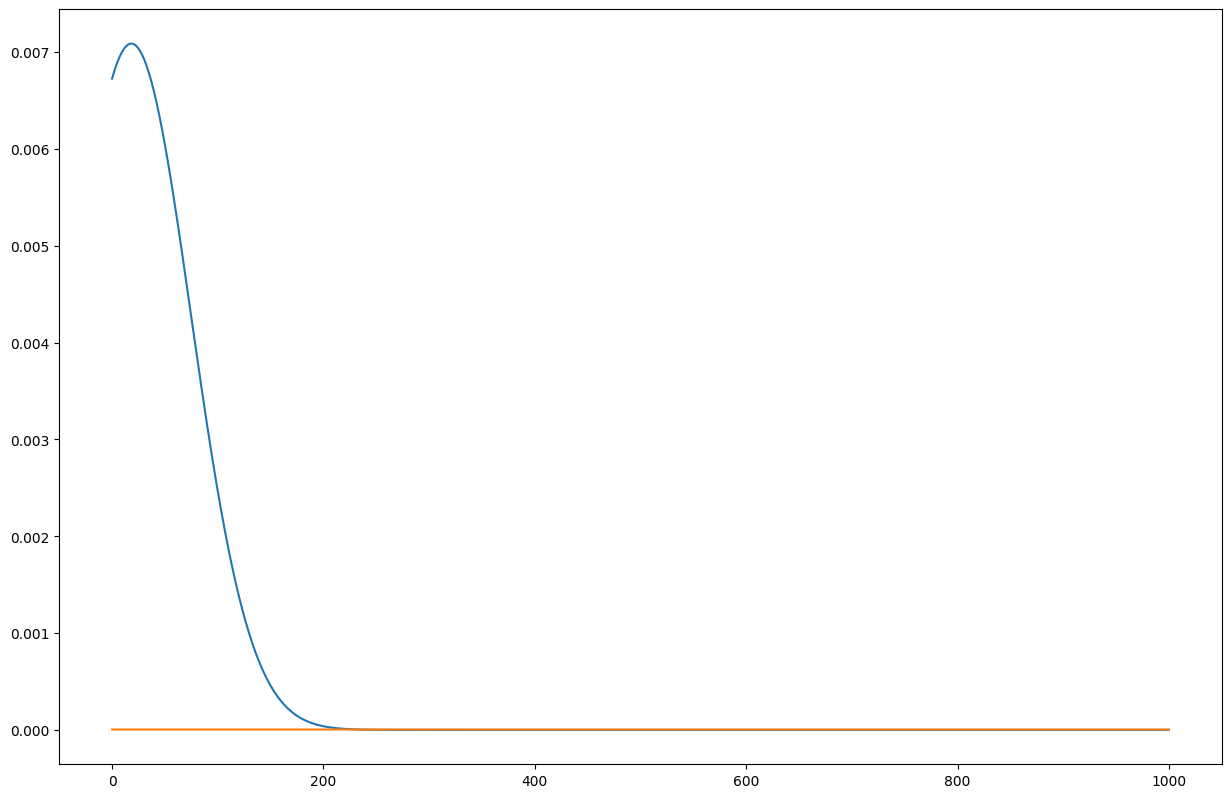

In [ ]:


figure(figsize=(15, 10), dpi=100)

# Plot between -10 an0.1d 10 with .001 steps.
xxx=np.arange(0, 1000, 0.01)
ww=scores_v[labels_v == 0][np.argsort(scores_v[labels_v == 0])]

x_axis =ww
qq=scores_v[labels_v == 1][np.argsort(scores_v[labels_v == 1])]
x2_axis = qq
print(x_axis)
print(x2_axis)
# Calculating mean and standard deviation
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
mean2 = statistics.mean(x2_axis)
sd2 = statistics.stdev(x2_axis)
print(mean)
print(sd)
print(mean2)
print(sd2)
plt.plot(xxx, (norm.pdf(xxx, mean, sd)))
plt.plot(xxx, norm.pdf(xxx, mean2, sd2))
plt.show()

In [ ]:
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])


result = solve(mean,mean2,sd,sd2)
print(result)

[ 233.44564939 -197.00533378]


In [ ]:
tp=0
tn=0
fp=0
fn=0
alpha=1.5
for i in indices_v:
  if scores_v[i]<mean +alpha*sd and scores_v[i]>mean-alpha*sd:
    if labels_v[i]==1:
      fn+=1
    else:
      tn+=1
  else:
    if labels_v[i]==1:
      tp+=1
    else:
      fp+=1
  # if labels_v[i]==0:
  #   if normal_min>=scores[i]:
  #     normal_min=scores[i]
    
  #   if normal_max<=scores[i]:
  #       normal_max=scores[i]
  # else:
     
  #   if anomal_min>=scores[i]:
  #     anomal_min=scores[i]
    
  #   if anomal_max<=scores[i]:
  #     anomal_max=scores[i]
precision = tp/(tp+fp)
recall= tp/(tp+fn)
print(precision, recall)
f1_score = 2*precision*recall/(precision+recall)
print(f1_score)

0.9444105070250458 0.6267991080478411
0.753503107103692


In [ ]:
normal_min=100
anomal_min=100
normal_max=-100
anomal_max=-100
tp=0
tn=0
fp=0
fn=0
alpha=0.2
for i in indices:
  if scores[i]<mean +alpha*sd and scores[i]>mean-alpha*sd:
    if labels[i]==1:
      fn+=1
    else:
      tn+=1
  else:
    if labels[i]==1:
      tp+=1
    else:
      fp+=1

print(tp, tn ,fp, fn)
precision = tp/(tp+fp)
recall= tp/(tp+fn)
print(precision, recall)
f1_score = 2*precision*recall/(precision+recall)
print(f1_score)



tpr = tp /(tp+fn)
fpr = fp /(fp+tn)
speci = 1-fpr
acc =  (tp+tn)/(tp+tn+fp+fn)
print("========")
print(tpr)
print(fpr)
print(speci)
print(acc)


14975 9972 18828 4760
0.4430080170399077 0.7588041550544717
0.5594157420897307
0.7588041550544717
0.65375
0.34624999999999995
0.5140002060368806


0.9008796906322499

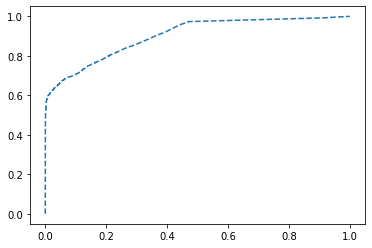

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

fpr, tpr, thresh= roc_curve(labels_v, scores_v)
pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
roc_auc_score(labels_v, scores_v)

In [ ]:
# torch.save(
#     {
#       'test_1': {
#           'desc': '520*520*1, K=5, ',
#           'lables': labels_v,
#           'scores': scores_v
#           }
#     }
# ,'/content/gdrive/MyDrive/ArshadPeoject/result/res.dict')

In [ ]:
print("normal_min =",normal_min)
print("anomal_min =",anomal_min)
print("normal_max =",normal_max)
print("anomal_max =",anomal_max)

normal_min = 100
anomal_min = 100
normal_max = -100
anomal_max = -100


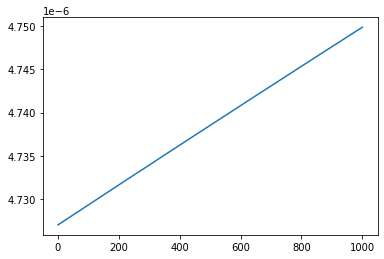

In [ ]:
plt.plot(xxx, norm.pdf(xxx, mean2, sd2))

In [ ]:

net_parameters = filter(lambda p: p.requires_grad, svdd.net.parameters())
params = sum([np.prod(p.size()) for p in net_parameters])
print('Trainable parameters: {}'.format(params))
print(svdd.net)

Trainable parameters: 23162
My_LeNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5n5): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2d1): BatchNorm2d(2, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2d2): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2d3): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2d4): BatchNorm2d(16, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (fc0): Linear(in_features=2704, out_features=8, bias=False)
)


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

dataset =My_Dataset(root="ll")
vertical_concat = pd.concat([dataset.test_set.data, dataset.test_set.anomal_data], axis=0,ignore_index=True)

cols=["col"]*200
for i in range(0,200):
  cols[i]="col-"+str(i)

# vv= vertical_concat.iloc[:,0:20]
# vv=pd.concat([vv,lbldf], axis=1)
# vv= vv.drop_duplicates()
# vv = pd.concat([vv, lbldf], axis=1)
print(vertical_concat)



pp = sns.pairplot(vertical_concat, vars=cols,hue='label',palette=['red','blue'])

# fig = pp.fig 
# fig.subplots_adjust(top=0.93, wspace=0.3)
# t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

AttributeError: ignored